<a href="https://colab.research.google.com/github/gudivadaakash/ecg-deep-learning/blob/main/notebook/ECG_deeplearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import h5py
import numpy as np
import os
from google.colab import drive

def truncate_data(data, length=2000):
    """
    Truncate the data to the specified length.

    Parameters:
    data (array): The original data array.
    length (int): The desired length of the truncated data. Default is 2000.

    Returns:
    array: Truncated data array.
    """
    return data[:, :length]

def process_h5_files(input_dir, output_dir, length=2000):
    """
    Process HDF5 files to truncate data to a specified length.

    Parameters:
    input_dir (str): Directory containing the input HDF5 files.
    output_dir (str): Directory to save the truncated HDF5 files.
    length (int): The desired length of the truncated data. Default is 2000.
    """
    if not os.path.exists(output_dir):
        try:
            os.makedirs(output_dir)
        except OSError as e:
            print(f"Error creating directory {output_dir}: {e}")
            return

    for filename in os.listdir(input_dir):
        if filename.endswith('.h5'):
            input_path = os.path.join(input_dir, filename)
            output_path = os.path.join(output_dir, filename)

            try:
                with h5py.File(input_path, 'r') as infile, h5py.File(output_path, 'w') as outfile:
                    for key in infile.keys():
                        data = infile[key][:]
                        truncated_data = truncate_data(data, length)
                        outfile.create_dataset(key, data=truncated_data)
                print(f"Processed {filename}")
            except Exception as e:
                print(f"Error processing file {input_path}: {e}")

# Define your Google Drive paths
input_directory = '/content/drive/MyDrive/147'
output_directory = '/content/drive/MyDrive/147t'

# Process the HDF5 files
process_h5_files(input_directory, output_directory)


Processed A00067.h5
Processed A00083.h5
Processed A00055.h5
Processed A00113.h5
Processed A00144.h5
Processed A00160.h5
Processed A00155.h5
Processed A00124.h5
Processed A00182.h5
Processed A00177.h5
Processed A00203.h5
Processed A00254.h5
Processed A00252.h5
Processed A00257.h5
Processed A00264.h5
Processed A00313.h5
Processed A00303.h5
Processed A00325.h5
Processed A00345.h5
Processed A00377.h5
Processed A00353.h5
Processed A00408.h5
Processed A00405.h5
Processed A00388.h5
Processed A00458.h5
Processed A00434.h5
Processed A00464.h5
Processed A00500.h5
Processed A00489.h5
Processed A00542.h5
Processed A00540.h5
Processed A00547.h5
Processed A00612.h5
Processed A00591.h5
Processed A00593.h5
Processed A00648.h5
Processed A00637.h5
Processed A00650.h5
Processed A00700.h5
Processed A00742.h5
Processed A00761.h5
Processed A00782.h5
Processed A00828.h5
Processed A00860.h5
Processed A00851.h5
Processed A00963.h5
Processed A00936.h5
Processed A00956.h5
Processed A01011.h5
Processed A01029.h5


In [ ]:
import os
import pandas as pd
import numpy as np
import h5py
from scipy.signal import find_peaks, butter, filtfilt

# Load mapping CSV file
mapping_df = pd.read_csv('/content/drive/MyDrive/metadata (1).csv')

# Convert 'TRUE'/'FALSE' to 1/0
mapping_df.replace({'TRUE': 1, 'FALSE': 0}, inplace=True)

# Butterworth filter for preprocessing
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

# Define a function to extract features from H5 files
def extract_features(file_path, sampling_rate=500):
    with h5py.File(file_path, 'r') as f:
        data = f['ecg'][:]  # Adjust according to actual dataset structure (12, N)

        features = {}
        duration = data.shape[1] / sampling_rate  # Total duration in seconds

        for channel_idx in range(data.shape[0]):
            channel_data = data[channel_idx, :]
            # Preprocess the data
            filtered_data = butter_bandpass_filter(channel_data, 0.5, 50, sampling_rate)

            # Detect QRS complexes
            distance = int(0.6 * sampling_rate)  # Minimum distance between peaks (600ms for a healthy heart rate)
            qrs_peaks, _ = find_peaks(filtered_data, distance=distance)

            if len(qrs_peaks) < 2:
                continue  # Skip this channel if not enough QRS complexes detected

            # Calculate RR intervals
            rr_intervals = np.diff(qrs_peaks) / sampling_rate  # Convert to time in seconds
            rr_mean = np.mean(rr_intervals) if len(rr_intervals) > 0 else np.nan

            # Detect T and P waves (simple method: find local maxima/minima in expected windows)
            t_wave_peaks = []
            p_wave_peaks = []
            for qrs_peak in qrs_peaks:
                # T wave detection (typically 200-400ms after QRS complex)
                t_wave_window = filtered_data[qrs_peak + int(0.2 * sampling_rate): qrs_peak + int(0.4 * sampling_rate)]
                if len(t_wave_window) > 0:
                    t_wave_peak = np.argmax(t_wave_window) + qrs_peak + int(0.2 * sampling_rate)
                    t_wave_peaks.append(t_wave_peak)

                # P wave detection (typically 100-200ms before QRS complex)
                p_wave_window = filtered_data[qrs_peak - int(0.2 * sampling_rate): qrs_peak - int(0.1 * sampling_rate)]
                if len(p_wave_window) > 0:
                    p_wave_peak = np.argmax(p_wave_window) + qrs_peak - int(0.2 * sampling_rate)
                    p_wave_peaks.append(p_wave_peak)

            # Ensure arrays are the same length for correlation calculation
            min_length = min(len(t_wave_peaks), len(qrs_peaks))
            if min_length > 0:
                t_wave_peaks = t_wave_peaks[:min_length]
                qrs_peaks = qrs_peaks[:min_length]
                correlation_t_st = np.corrcoef([filtered_data[t] for t in t_wave_peaks],
                                               [filtered_data[q] for q in qrs_peaks])[0, 1]
            else:
                correlation_t_st = np.nan

            # Calculate features based on identified waves
            t_wave_duration = np.ptp([filtered_data[t] for t in t_wave_peaks]) if len(t_wave_peaks) > 0 else np.nan
            t_wave_peak_value = np.max([filtered_data[t] for t in t_wave_peaks]) if len(t_wave_peaks) > 0 else np.nan
            t_wave_inversion = any(filtered_data[t] < 0 for t in t_wave_peaks) if len(t_wave_peaks) > 0 else np.nan
            t_wave_flattening = np.max(np.abs(np.gradient([filtered_data[t] for t in t_wave_peaks]))) < 0.1 if len(t_wave_peaks) > 0 else np.nan

            qrs_duration = np.ptp([filtered_data[q] for q in qrs_peaks]) if len(qrs_peaks) > 0 else np.nan
            qrs_amplitude = (np.max([filtered_data[q] for q in qrs_peaks]) -
                 np.min([filtered_data[q] for q in qrs_peaks])) if len(qrs_peaks) > 0 else np.nan

            bpm = 60 / rr_mean if rr_mean > 0 else np.nan

            p_wave_duration = np.ptp([filtered_data[p] for p in p_wave_peaks]) if len(p_wave_peaks) > 0 else np.nan

            st_elevation = np.max(filtered_data) if filtered_data.size > 0 else np.nan
            st_depression = np.min(filtered_data) if filtered_data.size > 0 else np.nan
            st_deviation = st_elevation - st_depression if filtered_data.size > 0 else np.nan

            features.update({
                f't_wave_duration_ch{channel_idx+1}': t_wave_duration,
                f't_wave_peak_value_ch{channel_idx+1}': t_wave_peak_value,
                f't_wave_inversion_ch{channel_idx+1}': t_wave_inversion,
                f't_wave_flattening_ch{channel_idx+1}': t_wave_flattening,
                f'rr_mean_ch{channel_idx+1}': rr_mean,
                f'qrs_duration_ch{channel_idx+1}': qrs_duration,
                f'qrs_amplitude_ch{channel_idx+1}': qrs_amplitude,
                f'bpm_ch{channel_idx+1}': bpm,
                f'p_wave_duration_ch{channel_idx+1}': p_wave_duration,
                f'st_elevation_ch{channel_idx+1}': st_elevation,
                f'st_depression_ch{channel_idx+1}': st_depression,
                f'st_deviation_ch{channel_idx+1}': st_deviation,
                f'correlation_t_st_ch{channel_idx+1}': correlation_t_st,
            })

        return features

# Directory containing all H5 files
h5_directory = '/content/drive/MyDrive/h5files'

def process_all_files(h5_directory, sampling_rate=500):
    all_features = []
    for file_name in os.listdir(h5_directory):
        if file_name.endswith('.h5'):
            file_path = os.path.join(h5_directory, file_name)
            features = extract_features(file_path, sampling_rate)
            features['ECG_ID'] = os.path.splitext(file_name)[0]
            all_features.append(features)
    return pd.DataFrame(all_features)

# Process all H5 files and save extracted features
df = process_all_files(h5_directory)
df.to_csv('extracted_features.csv', index=False)

# Load extracted features CSV file
extracted_features_df = pd.read_csv('extracted_features.csv')

# Merge with initial mapping CSV
final_df = mapping_df.merge(extracted_features_df, on='ECG_ID')

# Drop columns 3, 4, 5, and 6
final_df.drop(final_df.columns[[2, 3, 4, 5, 6]], axis=1, inplace=True)

# Drop rows and columns with all NaN values
final_df.dropna(axis=1, how='all', inplace=True)
final_df.dropna(axis=0, how='all', inplace=True)

# Save the final integrated CSV
final_df.to_csv('final_output.csv', index=False)


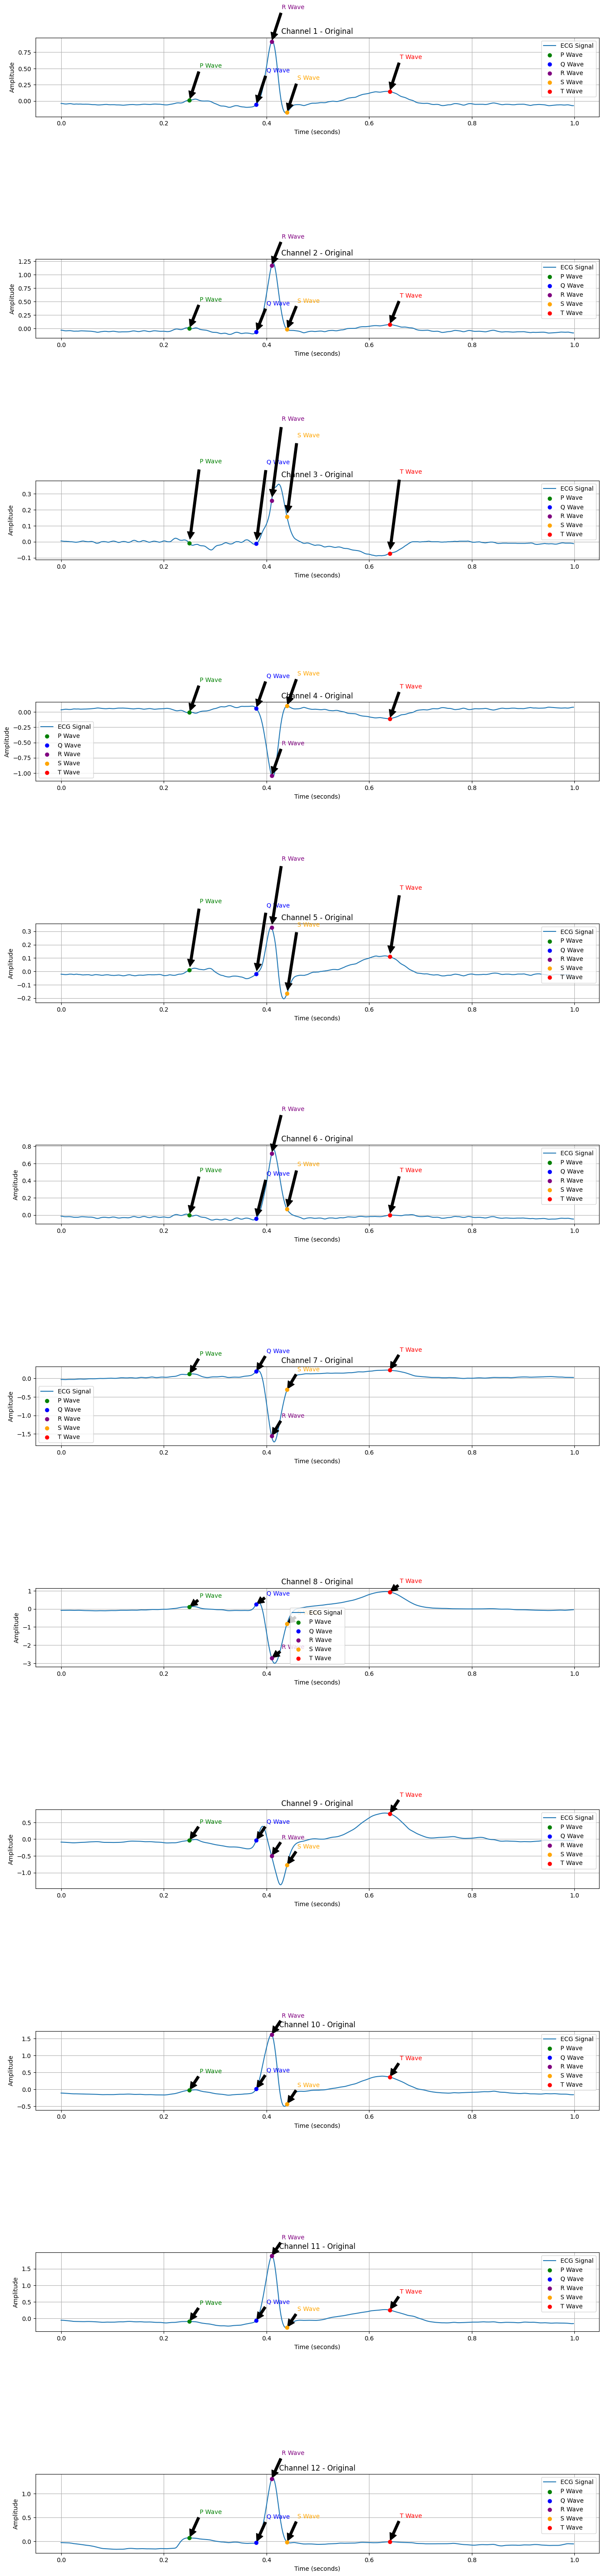

In [ ]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

def plot_few_data_points_with_pqrst_points(file_path, sampling_rate=500, num_points=500):
    try:
        with h5py.File(file_path, 'r') as f:
            data = f['ecg'][:]  # Adjust according to actual dataset structure

            num_channels = data.shape[0]
            time = np.arange(num_points) / sampling_rate

            fig, axs = plt.subplots(num_channels, 1, figsize=(14, 5 * num_channels))

            # Specific indices for PQRST points (for demonstration purposes)
            p_index = 125
            q_index = 190
            r_index = 205
            s_index = 220
            t_index = 320

            for channel_idx in range(num_channels):
                channel_data = data[channel_idx, :num_points]

                axs[channel_idx].plot(time, channel_data, label='ECG Signal')
                axs[channel_idx].set_title(f'Channel {channel_idx + 1} - Original')
                axs[channel_idx].set_xlabel('Time (seconds)')
                axs[channel_idx].set_ylabel('Amplitude')
                axs[channel_idx].grid(True)

                # Annotate PQRST points
                axs[channel_idx].scatter(time[p_index], channel_data[p_index], color='green', label='P Wave', zorder=5)
                axs[channel_idx].scatter(time[q_index], channel_data[q_index], color='blue', label='Q Wave', zorder=5)
                axs[channel_idx].scatter(time[r_index], channel_data[r_index], color='purple', label='R Wave', zorder=5)
                axs[channel_idx].scatter(time[s_index], channel_data[s_index], color='orange', label='S Wave', zorder=5)
                axs[channel_idx].scatter(time[t_index], channel_data[t_index], color='red', label='T Wave', zorder=5)

                # Annotate each point with text
                axs[channel_idx].annotate('P Wave', xy=(time[p_index], channel_data[p_index]),
                                         xytext=(time[p_index] + 0.02, channel_data[p_index] + 0.5),
                                         arrowprops=dict(facecolor='black', shrink=0.05),
                                         fontsize=10, color='green')

                axs[channel_idx].annotate('Q Wave', xy=(time[q_index], channel_data[q_index]),
                                         xytext=(time[q_index] + 0.02, channel_data[q_index] + 0.5),
                                         arrowprops=dict(facecolor='black', shrink=0.05),
                                         fontsize=10, color='blue')

                axs[channel_idx].annotate('R Wave', xy=(time[r_index], channel_data[r_index]),
                                         xytext=(time[r_index] + 0.02, channel_data[r_index] + 0.5),
                                         arrowprops=dict(facecolor='black', shrink=0.05),
                                         fontsize=10, color='purple')

                axs[channel_idx].annotate('S Wave', xy=(time[s_index], channel_data[s_index]),
                                         xytext=(time[s_index] + 0.02, channel_data[s_index] + 0.5),
                                         arrowprops=dict(facecolor='black', shrink=0.05),
                                         fontsize=10, color='orange')

                axs[channel_idx].annotate('T Wave', xy=(time[t_index], channel_data[t_index]),
                                         xytext=(time[t_index] + 0.02, channel_data[t_index] + 0.5),
                                         arrowprops=dict(facecolor='black', shrink=0.05),
                                         fontsize=10, color='red')

                axs[channel_idx].legend()

            plt.tight_layout()
            plt.show()
    except Exception as e:
        print(f"An error occurred: {e}")

# Example usage
file_path = r'/content/drive/MyDrive/records1/records/A00002.h5'  # Replace with your H5 file path
plot_few_data_points_with_pqrst_points(file_path, num_points=500)


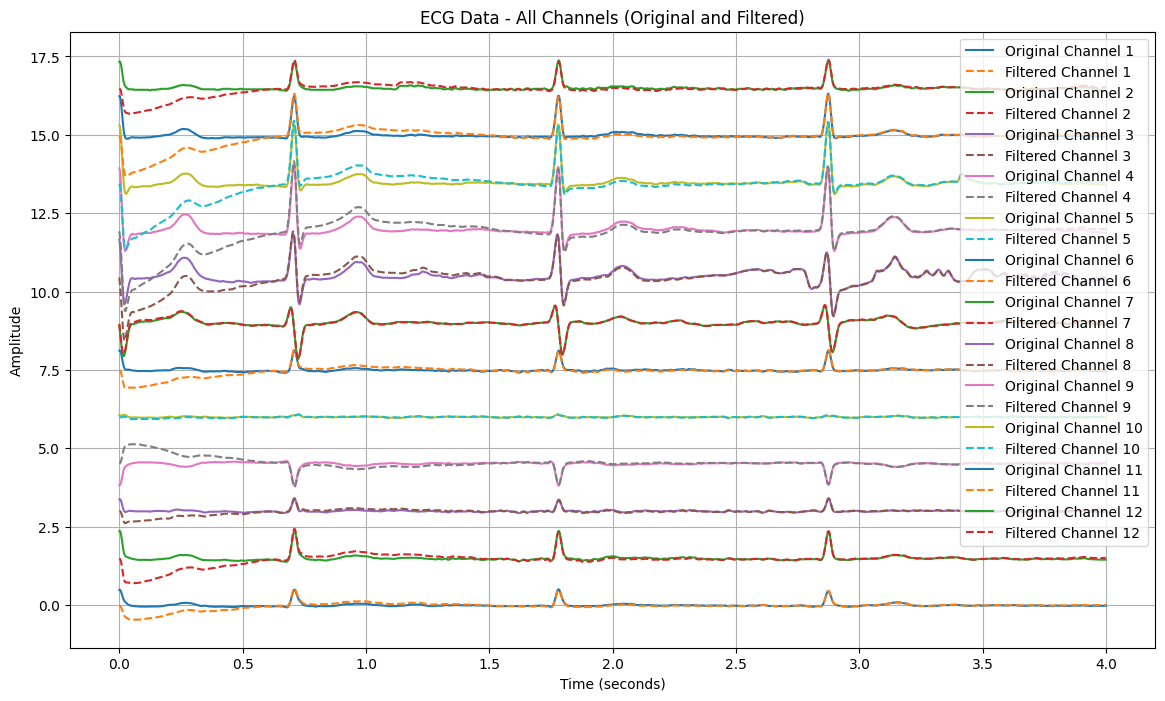

In [ ]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt

# Butterworth filter for preprocessing
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

# Function to read and plot all ECG channels before and after filtering in a single plot
def plot_all_channels_together(file_path, sampling_rate=500):
    with h5py.File(file_path, 'r') as f:
        data = f['ecg'][:]  # Adjust according to actual dataset structure (12, N)

        num_channels = data.shape[0]
        time = np.arange(data.shape[1]) / sampling_rate

        plt.figure(figsize=(14, 8))

        for channel_idx in range(num_channels):
            channel_data = data[channel_idx, :]
            filtered_data = butter_bandpass_filter(channel_data, 0.5, 50, sampling_rate)

            plt.plot(time, channel_data + channel_idx * 1.5, label=f'Original Channel {channel_idx + 1}')
            plt.plot(time, filtered_data + channel_idx * 1.5, label=f'Filtered Channel {channel_idx + 1}', linestyle='--')

        plt.title('ECG Data - All Channels (Original and Filtered)')
        plt.xlabel('Time (seconds)')
        plt.ylabel('Amplitude')
        plt.legend(loc='upper right')
        plt.grid(True)
        plt.show()

# Example usage
file_path = r'/content/drive/MyDrive/h5files/A00136.h5'  # Replace with your H5 file path
plot_all_channels_together(file_path)


In [ ]:
import pandas as pd

# Load the CSV file into a DataFrame
data = pd.read_csv('/content/final_output.csv')

# List of column suffixes to convert from True/False to 1/0
columns_to_convert = [
    't_wave_inversion_ch1', 't_wave_flattening_ch1',
    't_wave_inversion_ch2', 't_wave_flattening_ch2',
    't_wave_inversion_ch3', 't_wave_flattening_ch3',
    't_wave_inversion_ch4', 't_wave_flattening_ch4',
    't_wave_inversion_ch5', 't_wave_flattening_ch5',
    't_wave_inversion_ch6', 't_wave_flattening_ch6',
    't_wave_inversion_ch7', 't_wave_flattening_ch7',
    't_wave_inversion_ch8', 't_wave_flattening_ch8',
    't_wave_inversion_ch9', 't_wave_flattening_ch9',
    't_wave_inversion_ch10', 't_wave_flattening_ch10',
    't_wave_inversion_ch11', 't_wave_flattening_ch11',
    't_wave_inversion_ch12', 't_wave_flattening_ch12'
]

# Convert 'True'/'False' to 1/0 for the specified columns
for col in columns_to_convert:
    data[col] = data[col].astype(int)

# Verify the conversion
print(data[columns_to_convert].head())

# Save the updated DataFrame to a new CSV file
data.to_csv('new_updated.csv', index=False)

   t_wave_inversion_ch1  t_wave_flattening_ch1  t_wave_inversion_ch2  \
0                     1                      1                     1   
1                     0                      1                     0   
2                     0                      1                     0   
3                     0                      0                     1   
4                     0                      1                     0   

   t_wave_flattening_ch2  t_wave_inversion_ch3  t_wave_flattening_ch3  \
0                      1                     1                      0   
1                      1                     0                      1   
2                      1                     0                      1   
3                      0                     0                      0   
4                      1                     0                      1   

   t_wave_inversion_ch4  t_wave_flattening_ch4  t_wave_inversion_ch5  \
0                     0                      1          

Number of samples before SMOTE:
4    550
3    394
2    371
1    163
0    159
Name: count, dtype: int64
Number of samples after SMOTE:
3    550
4    550
0    550
2    550
1    550
Name: count, dtype: int64
Label Mapping (Original -> Encoded):
{50: 0, 60: 1, 145: 2, 146: 3, 147: 4}
Decision Tree Accuracy: 0.6181818181818182
Decision Tree Classification Report:
              precision    recall  f1-score   support

          50       0.80      0.78      0.79        99
          60       0.78      0.80      0.79       120
         145       0.54      0.54      0.54       112
         146       0.52      0.52      0.52       106
         147       0.46      0.45      0.45       113

    accuracy                           0.62       550
   macro avg       0.62      0.62      0.62       550
weighted avg       0.62      0.62      0.62       550



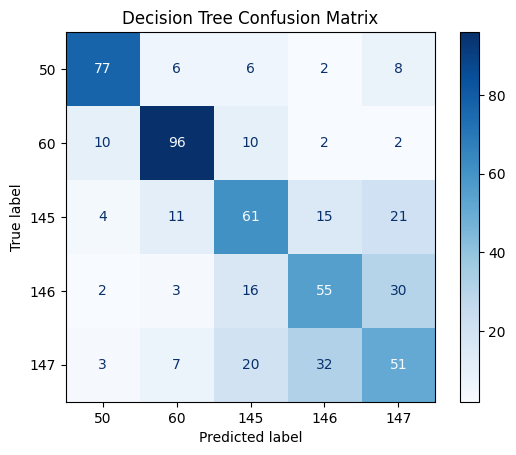

Random Forest Accuracy: 0.7327272727272728
Random Forest Classification Report:
              precision    recall  f1-score   support

          50       0.84      0.90      0.87        99
          60       0.89      0.93      0.91       120
         145       0.71      0.67      0.69       112
         146       0.61      0.73      0.66       106
         147       0.59      0.45      0.51       113

    accuracy                           0.73       550
   macro avg       0.73      0.73      0.73       550
weighted avg       0.73      0.73      0.73       550



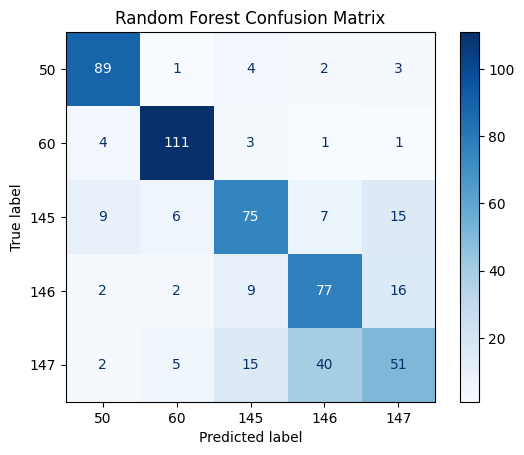

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('/content/new_updated.csv')

# Split the features and labels
X = df.iloc[:, 2:]  # Selecting all columns from the first channel's features onwards
y = df['AHA_Code']  # Assuming 'AHA_Code' is the label

# Encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

from imblearn.over_sampling import SMOTE
# Print the number of samples before SMOTE
print("Number of samples before SMOTE:")
print(pd.Series(y_encoded).value_counts())

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y_encoded)

# Print the number of samples after SMOTE
print("Number of samples after SMOTE:")
print(pd.Series(y_resampled).value_counts())

# Standardize the features after SMOTE
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

# Print the mapping of original labels to integer values
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping (Original -> Encoded):")
print(label_mapping)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_resampled, test_size=0.2, random_state=42)

# Train a Decision Tree classifier
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train, y_train)

# Evaluate the Decision Tree classifier
y_pred_dt = decision_tree.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f'Decision Tree Accuracy: {accuracy_dt}')

# Print the Decision Tree classification report
class_report_dt = classification_report(y_test, y_pred_dt, target_names=label_encoder.classes_.astype(str))
print("Decision Tree Classification Report:")
print(class_report_dt)

# Compute and display the Decision Tree confusion matrix
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
disp_dt = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_dt, display_labels=label_encoder.classes_)
disp_dt.plot(cmap=plt.cm.Blues)
plt.title('Decision Tree Confusion Matrix')
plt.show()

# Train a Random Forest classifier
random_forest = RandomForestClassifier(random_state=42)
random_forest.fit(X_train, y_train)

# Evaluate the Random Forest classifier
y_pred_rf = random_forest.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Accuracy: {accuracy_rf}')

# Print the Random Forest classification report
class_report_rf = classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_.astype(str))
print("Random Forest Classification Report:")
print(class_report_rf)

# Compute and display the Random Forest confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_rf, display_labels=label_encoder.classes_)
disp_rf.plot(cmap=plt.cm.Blues)
plt.title('Random Forest Confusion Matrix')
plt.show()


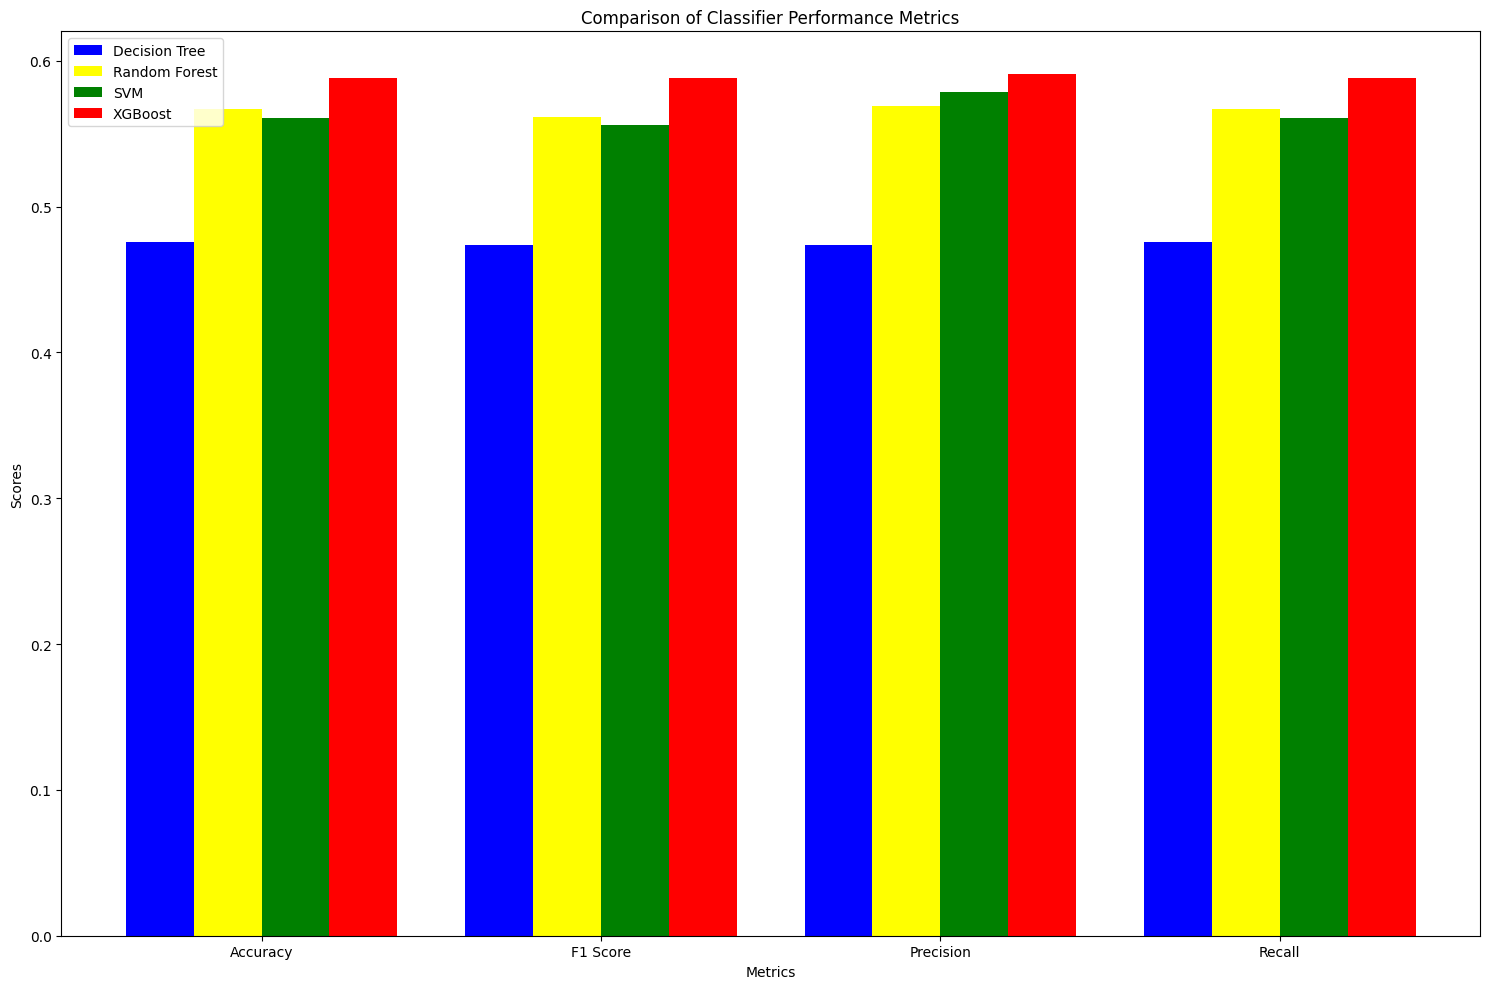

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('/content/new_updated.csv')

# Split the features and labels
X = df.iloc[:, 2:]  # Selecting all columns from the first channel's features onwards
y = df['AHA_Code']  # Assuming 'AHA_Code' is the label

# Encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# Dictionary to store the metrics
metrics = {
    "Classifier": [],
    "Accuracy": [],
    "F1 Score": [],
    "Precision": [],
    "Recall": []
}

# Train and evaluate a Decision Tree classifier
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train, y_train)
y_pred_dt = decision_tree.predict(X_test)
metrics["Classifier"].append("Decision Tree")
metrics["Accuracy"].append(accuracy_score(y_test, y_pred_dt))
metrics["F1 Score"].append(f1_score(y_test, y_pred_dt, average='weighted'))
metrics["Precision"].append(precision_score(y_test, y_pred_dt, average='weighted'))
metrics["Recall"].append(recall_score(y_test, y_pred_dt, average='weighted'))

# Train and evaluate a Random Forest classifier
random_forest = RandomForestClassifier(random_state=42)
random_forest.fit(X_train, y_train)
y_pred_rf = random_forest.predict(X_test)
metrics["Classifier"].append("Random Forest")
metrics["Accuracy"].append(accuracy_score(y_test, y_pred_rf))
metrics["F1 Score"].append(f1_score(y_test, y_pred_rf, average='weighted'))
metrics["Precision"].append(precision_score(y_test, y_pred_rf, average='weighted'))
metrics["Recall"].append(recall_score(y_test, y_pred_rf, average='weighted'))

# Train and evaluate an SVM classifier
svm = SVC(random_state=42)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
metrics["Classifier"].append("SVM")
metrics["Accuracy"].append(accuracy_score(y_test, y_pred_svm))
metrics["F1 Score"].append(f1_score(y_test, y_pred_svm, average='weighted'))
metrics["Precision"].append(precision_score(y_test, y_pred_svm, average='weighted'))
metrics["Recall"].append(recall_score(y_test, y_pred_svm, average='weighted'))

# Train and evaluate an XGBoost classifier
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
metrics["Classifier"].append("XGBoost")
metrics["Accuracy"].append(accuracy_score(y_test, y_pred_xgb))
metrics["F1 Score"].append(f1_score(y_test, y_pred_xgb, average='weighted'))
metrics["Precision"].append(precision_score(y_test, y_pred_xgb, average='weighted'))
metrics["Recall"].append(recall_score(y_test, y_pred_xgb, average='weighted'))

# Create a DataFrame from the metrics dictionary
metrics_df = pd.DataFrame(metrics)

# Transpose the DataFrame for plotting
metrics_df = metrics_df.set_index('Classifier').T

# Plot the metrics
fig, ax = plt.subplots(figsize=(15, 10))

index = np.arange(len(metrics_df))
bar_width = 0.2

bar1 = ax.bar(index, metrics_df['Decision Tree'], bar_width, label='Decision Tree', color='blue')
bar2 = ax.bar(index + bar_width, metrics_df['Random Forest'], bar_width, label='Random Forest', color='yellow')
bar3 = ax.bar(index + 2 * bar_width, metrics_df['SVM'], bar_width, label='SVM', color='green')
bar4 = ax.bar(index + 3 * bar_width, metrics_df['XGBoost'], bar_width, label='XGBoost', color='red')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Classifier Performance Metrics')
ax.set_xticks(index + 1.5 * bar_width)
ax.set_xticklabels(metrics_df.index)
ax.legend()

plt.tight_layout()
plt.show()


Number of samples before SMOTE:
4    550
3    394
2    371
1    163
0    159
Name: count, dtype: int64
Number of samples after SMOTE:
3    550
4    550
0    550
2    550
1    550
Name: count, dtype: int64
Decision Tree Classification Report:
              precision    recall  f1-score   support

          50       0.80      0.78      0.79        99
          60       0.78      0.80      0.79       120
         145       0.54      0.54      0.54       112
         146       0.52      0.52      0.52       106
         147       0.46      0.45      0.45       113

    accuracy                           0.62       550
   macro avg       0.62      0.62      0.62       550
weighted avg       0.62      0.62      0.62       550



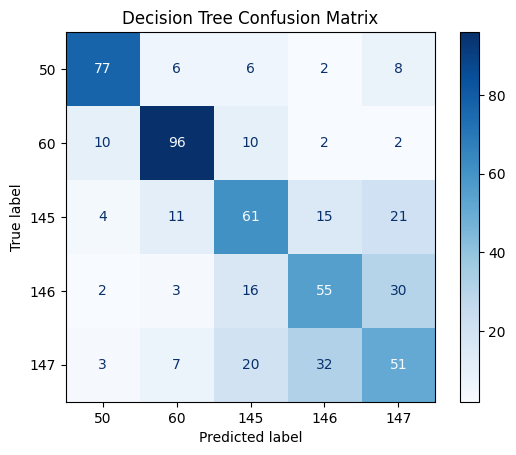

Random Forest Classification Report:
              precision    recall  f1-score   support

          50       0.84      0.90      0.87        99
          60       0.89      0.93      0.91       120
         145       0.71      0.67      0.69       112
         146       0.61      0.73      0.66       106
         147       0.59      0.45      0.51       113

    accuracy                           0.73       550
   macro avg       0.73      0.73      0.73       550
weighted avg       0.73      0.73      0.73       550



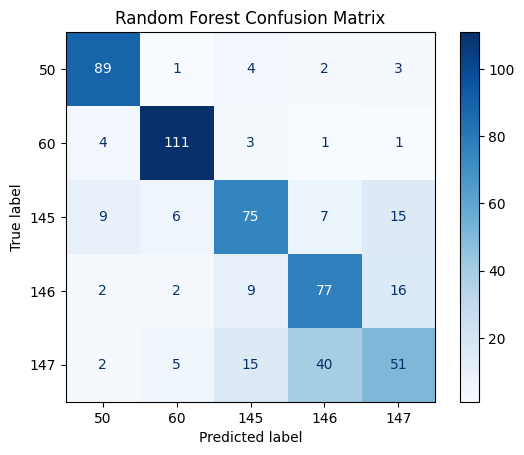

SVM Classification Report:
              precision    recall  f1-score   support

          50       0.88      0.88      0.88        99
          60       0.92      0.91      0.91       120
         145       0.66      0.69      0.68       112
         146       0.62      0.64      0.63       106
         147       0.58      0.55      0.57       113

    accuracy                           0.73       550
   macro avg       0.73      0.73      0.73       550
weighted avg       0.73      0.73      0.73       550



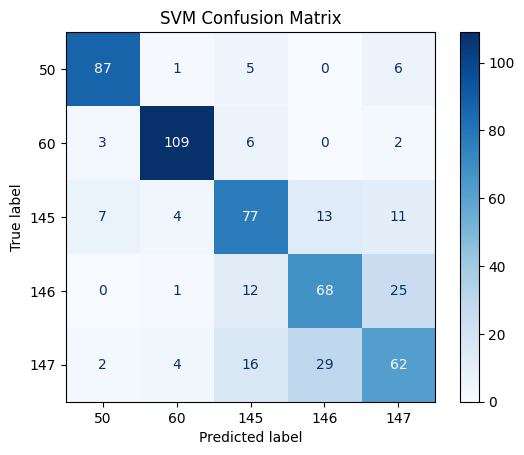

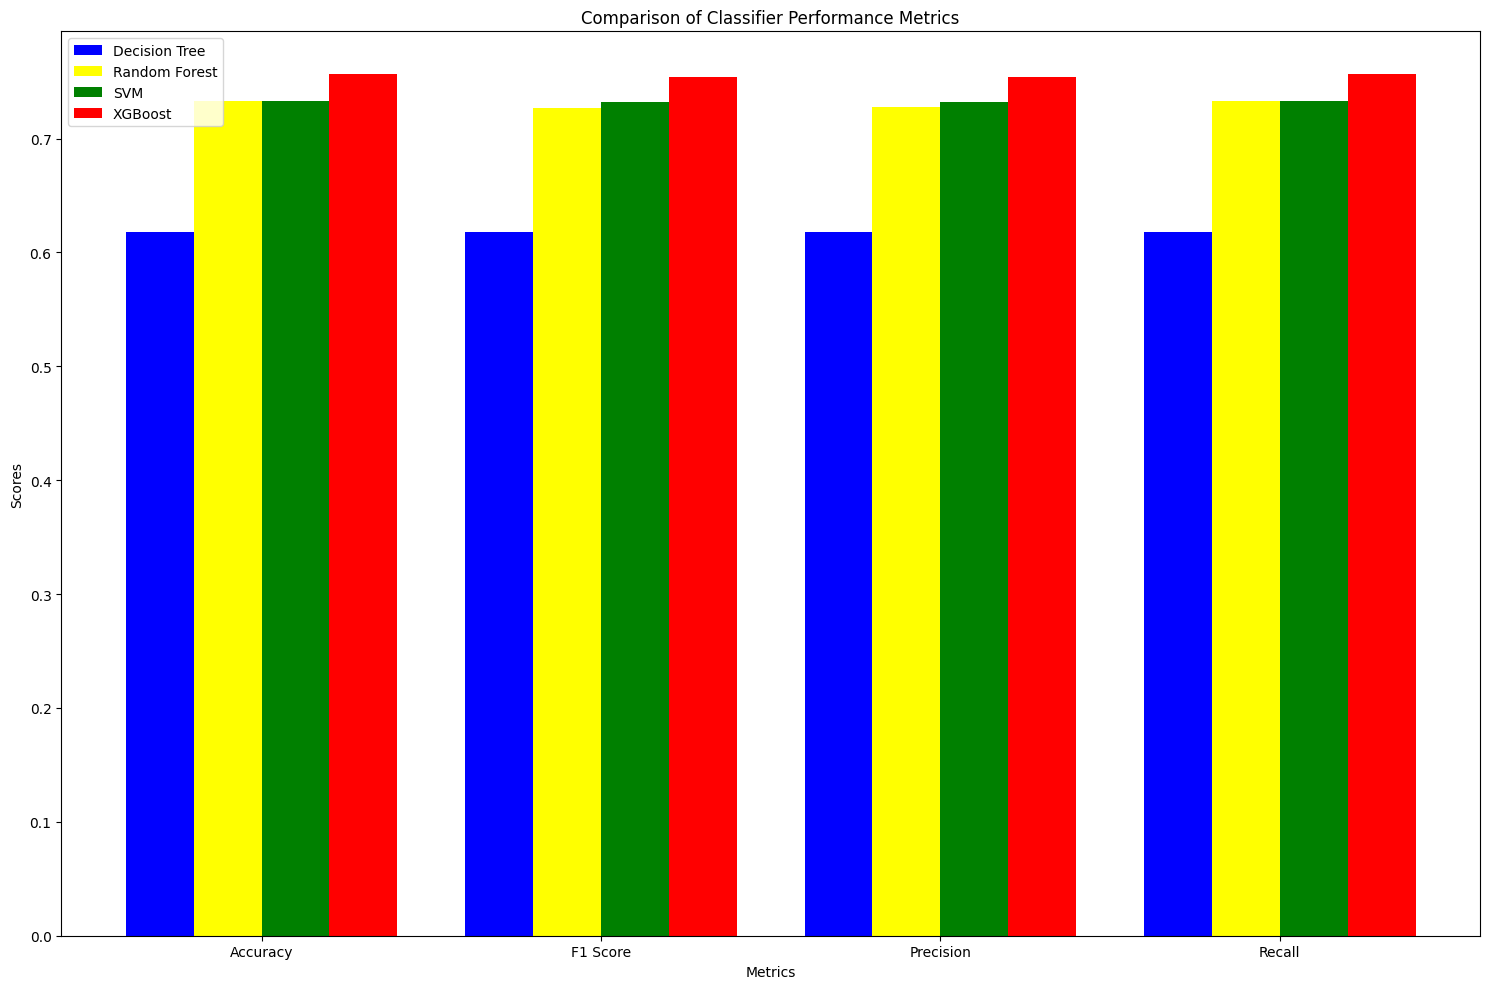

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

# Load the data
df = pd.read_csv('/content/new_updated.csv')

# Split the features and labels
X = df.iloc[:, 2:]  # Selecting all columns from the first channel's features onwards
y = df['AHA_Code']  # Assuming 'AHA_Code' is the label

# Encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Print the number of samples before SMOTE
print("Number of samples before SMOTE:")
print(pd.Series(y_encoded).value_counts())

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y_encoded)

# Print the number of samples after SMOTE
print("Number of samples after SMOTE:")
print(pd.Series(y_resampled).value_counts())

# Standardize the features after SMOTE
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_resampled, test_size=0.2, random_state=42)

# Dictionary to store the metrics
metrics = {
    "Classifier": [],
    "Accuracy": [],
    "F1 Score": [],
    "Precision": [],
    "Recall": []
}

# Train and evaluate a Decision Tree classifier
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train, y_train)
y_pred_dt = decision_tree.predict(X_test)
metrics["Classifier"].append("Decision Tree")
metrics["Accuracy"].append(accuracy_score(y_test, y_pred_dt))
metrics["F1 Score"].append(f1_score(y_test, y_pred_dt, average='weighted'))
metrics["Precision"].append(precision_score(y_test, y_pred_dt, average='weighted'))
metrics["Recall"].append(recall_score(y_test, y_pred_dt, average='weighted'))

# Print the Decision Tree classification report
print("Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_dt, target_names=label_encoder.classes_.astype(str)))

# Compute and display the Decision Tree confusion matrix
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
disp_dt = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_dt, display_labels=label_encoder.classes_)
disp_dt.plot(cmap=plt.cm.Blues)
plt.title('Decision Tree Confusion Matrix')
plt.show()

# Train and evaluate a Random Forest classifier
random_forest = RandomForestClassifier(random_state=42)
random_forest.fit(X_train, y_train)
y_pred_rf = random_forest.predict(X_test)
metrics["Classifier"].append("Random Forest")
metrics["Accuracy"].append(accuracy_score(y_test, y_pred_rf))
metrics["F1 Score"].append(f1_score(y_test, y_pred_rf, average='weighted'))
metrics["Precision"].append(precision_score(y_test, y_pred_rf, average='weighted'))
metrics["Recall"].append(recall_score(y_test, y_pred_rf, average='weighted'))

# Print the Random Forest classification report
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_.astype(str)))

# Compute and display the Random Forest confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_rf, display_labels=label_encoder.classes_)
disp_rf.plot(cmap=plt.cm.Blues)
plt.title('Random Forest Confusion Matrix')
plt.show()

# Train and evaluate an SVM classifier
svm = SVC(random_state=42)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
metrics["Classifier"].append("SVM")
metrics["Accuracy"].append(accuracy_score(y_test, y_pred_svm))
metrics["F1 Score"].append(f1_score(y_test, y_pred_svm, average='weighted'))
metrics["Precision"].append(precision_score(y_test, y_pred_svm, average='weighted'))
metrics["Recall"].append(recall_score(y_test, y_pred_svm, average='weighted'))

# Print the SVM classification report
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm, target_names=label_encoder.classes_.astype(str)))

# Compute and display the SVM confusion matrix
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
disp_svm = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_svm, display_labels=label_encoder.classes_)
disp_svm.plot(cmap=plt.cm.Blues)
plt.title('SVM Confusion Matrix')
plt.show()

# Train and evaluate an XGBoost classifier
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
metrics["Classifier"].append("XGBoost")
metrics["Accuracy"].append(accuracy_score(y_test, y_pred_xgb))
metrics["F1 Score"].append(f1_score(y_test, y_pred_xgb, average='weighted'))
metrics["Precision"].append(precision_score(y_test, y_pred_xgb, average='weighted'))
metrics["Recall"].append(recall_score(y_test, y_pred_xgb, average='weighted'))

# Create a DataFrame from the metrics dictionary
metrics_df = pd.DataFrame(metrics)

# Transpose the DataFrame for plotting
metrics_df = metrics_df.set_index('Classifier').T

# Plot the metrics
fig, ax = plt.subplots(figsize=(15, 10))

index = np.arange(len(metrics_df))
bar_width = 0.2

bar1 = ax.bar(index, metrics_df['Decision Tree'], bar_width, label='Decision Tree', color='blue')
bar2 = ax.bar(index + bar_width, metrics_df['Random Forest'], bar_width, label='Random Forest', color='yellow')
bar3 = ax.bar(index + 2 * bar_width, metrics_df['SVM'], bar_width, label='SVM', color='green')
bar4 = ax.bar(index + 3 * bar_width, metrics_df['XGBoost'], bar_width, label='XGBoost', color='red')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Classifier Performance Metrics')
ax.set_xticks(index + 1.5 * bar_width)
ax.set_xticklabels(metrics_df.index)
ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('/content/new_updated (1).csv')

# Split the features and labels
X = df.iloc[:, 2:]  # Selecting all columns from the first channel's features onwards
y = df['AHA_Code']  # Assuming 'AHA_Code' is the label

# Ensure there are no NaN values
X = X.fillna(0)

# Encode the labels if necessary
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

num_classes = len(np.unique(y_encoded))
print(f"Number of unique classes: {num_classes}")
print(f"Unique classes: {np.unique(y_encoded)}")

from collections import Counter

# Count the number of samples for each class
class_counts = Counter(y_encoded)

# Print the number of samples for each class
for class_label, count in class_counts.items():
    print(f"Class {class_label}: {count} samples")


# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# Reshape data for 1D CNN
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build the improved 1D CNN model
model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.1),

    Conv1D(filters=16, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.1),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')  # Adjust output layer for number of classes
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

# Predict the classes for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_.astype(str))
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Print the classification report
class_report = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_.astype(str))
print(class_report)


FileNotFoundError: [Errno 2] No such file or directory: '/content/new_updated (1).csv'

In [ ]:
!pip install deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 932.2 kB/s eta 0:00:00


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np
from deap import base, creator, tools, algorithms
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Load the dataset
df = pd.read_csv('/content/new_updated.csv')

# Split the features and labels
X = df.iloc[:, 2:]  # Selecting all columns from the first channel's features onwards
y = df['AHA_Code']

# Get the column names
feature_names = X.columns

# Preprocess the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define the fitness function
def evaluate(individual):
    selected_features = [index for index, value in enumerate(individual) if value == 1]
    if len(selected_features) == 0:
        return 0,

    X_selected = X_scaled[:, selected_features]
    clf = RandomForestClassifier(n_estimators=50, random_state=42)
    cv_scores = cross_val_score(clf, X_selected, y, cv=5, scoring='accuracy')
    return np.mean(cv_scores),

# Define the genetic algorithm
toolbox = base.Toolbox()

# Define the individual and population
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Attribute generator
toolbox.register("attr_bool", np.random.randint, 2)

# Structure initializers
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=X.shape[1])
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Genetic operators
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)

# Run the genetic algorithm
def main():
    population = toolbox.population(n=50)
    n_generations = 20

    # Apply the genetic algorithm
    algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=n_generations,
                        stats=None, halloffame=None, verbose=True)

    # Get the best individual
    best_individual = tools.selBest(population, k=1)[0]
    print("Best individual is: %s\nwith fitness: %s" % (best_individual, best_individual.fitness.values))

    # Get the selected features
    selected_features = [index for index, value in enumerate(best_individual) if value == 1]
    print("Selected features indices: ", selected_features)

    # Get the names of the selected features
    selected_feature_names = [feature_names[i] for i in selected_features]
    print("Selected feature names: ", selected_feature_names)

if __name__ == "__main__":
    main()


gen	nevals
0  	50    
1  	28    
2  	35    
3  	25    
4  	26    
5  	29    
6  	32    
7  	26    
8  	30    
9  	30    
10 	37    
11 	31    
12 	40    
13 	26    
14 	33    
15 	40    
16 	33    
17 	27    
18 	27    
19 	27    
20 	32    
Best individual is: [0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1]
with fitness: (0.571175505333035,)
Selected features indices:  [1, 5, 7, 10, 11, 12, 14, 15, 17, 22, 25, 28, 29, 30, 31, 33, 35, 37, 39, 40, 42, 43, 45, 46, 51, 52, 55, 63, 66, 67, 68, 70, 77, 79, 80, 81, 84, 86, 87, 89, 90, 91, 92, 93, 94, 96, 103, 104, 106, 107, 109,

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from imblearn.over_sampling import SMote
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_csv('/content/new_updated.csv')

# Define selected features from GA
selected_features = ['t_wave_peak_value_ch1', 'qrs_duration_ch1', 'bpm_ch1', 'st_depression_ch1', 'st_deviation_ch1', 'correlation_t_st_ch1', 't_wave_peak_value_ch2', 't_wave_inversion_ch2', 'rr_mean_ch2', 'st_elevation_ch2', 'correlation_t_st_ch2', 't_wave_inversion_ch3', 't_wave_flattening_ch3', 'rr_mean_ch3', 'qrs_duration_ch3', 'bpm_ch3', 'st_elevation_ch3', 'st_deviation_ch3', 't_wave_duration_ch4', 't_wave_peak_value_ch4', 't_wave_flattening_ch4', 'rr_mean_ch4', 'qrs_amplitude_ch4', 'bpm_ch4', 'correlation_t_st_ch4', 't_wave_duration_ch5', 't_wave_flattening_ch5', 'st_deviation_ch5', 't_wave_peak_value_ch6', 't_wave_inversion_ch6', 't_wave_flattening_ch6', 'qrs_duration_ch6', 'correlation_t_st_ch6', 't_wave_peak_value_ch7', 't_wave_inversion_ch7', 't_wave_flattening_ch7', 'qrs_amplitude_ch7', 'p_wave_duration_ch7', 'st_elevation_ch7', 'st_deviation_ch7', 'correlation_t_st_ch7', 't_wave_duration_ch8', 't_wave_peak_value_ch8', 't_wave_inversion_ch8', 't_wave_flattening_ch8', 'qrs_duration_ch8', 'correlation_t_st_ch8', 't_wave_duration_ch9', 't_wave_inversion_ch9', 't_wave_flattening_ch9', 'qrs_duration_ch9', 'st_deviation_ch9', 'correlation_t_st_ch9', 't_wave_duration_ch10', 't_wave_peak_value_ch10', 't_wave_inversion_ch10', 't_wave_flattening_ch10', 'qrs_amplitude_ch10', 'bpm_ch10', 'st_depression_ch10', 'st_deviation_ch10', 't_wave_duration_ch11', 't_wave_peak_value_ch11', 't_wave_inversion_ch11', 't_wave_flattening_ch11', 'qrs_duration_ch11', 'st_deviation_ch11', 'correlation_t_st_ch11', 't_wave_peak_value_ch12', 't_wave_inversion_ch12', 'bpm_ch12', 'p_wave_duration_ch12', 'st_elevation_ch12', 'st_deviation_ch12', 'correlation_t_st_ch12']

# Extract numeric feature columns
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
all_features = [col for col in numeric_columns if col != 'AHA_Code']

# Define the classifiers
classifiers = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(kernel='linear', random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

# Function to process the data and compute metrics
def compute_metrics(features):
    X = df[features]
    y = df['AHA_Code']
    X = X.fillna(0)
    y = y.fillna(0)
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y_encoded)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_resampled)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_resampled, test_size=0.2, random_state=42)
    metrics = {
        "Classifier": [],
        "Accuracy": [],
        "F1 Score": [],
        "Precision": [],
        "Recall": []
    }
    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        metrics["Classifier"].append(name)
        metrics["Accuracy"].append(accuracy_score(y_test, y_pred))
        metrics["F1 Score"].append(f1_score(y_test, y_pred, average='weighted'))
        metrics["Precision"].append(precision_score(y_test, y_pred, average='weighted'))
        metrics["Recall"].append(recall_score(y_test, y_pred, average='weighted'))
    return pd.DataFrame(metrics)

# Compute metrics for selected features
metrics_selected = compute_metrics(selected_features)

# Compute metrics for all features
metrics_all = compute_metrics(all_features)

# Add a column indicating the feature set
metrics_selected['Feature Set'] = 'Selected Features'
metrics_all['Feature Set'] = 'All Features'

# Combine the metrics DataFrames
metrics_combined = pd.concat([metrics_selected, metrics_all])

# Plot the metrics as bar graphs
fig, axes = plt.subplots(2, 2, figsize=(20, 12), sharey=True)
metrics_combined_melted = metrics_combined.melt(id_vars=["Classifier", "Feature Set"], var_name="Metric", value_name="Score")

for ax, metric in zip(axes.ravel(), ["Accuracy", "F1 Score", "Precision", "Recall"]):
    sns.barplot(data=metrics_combined_melted[metrics_combined_melted["Metric"] == metric],
                x="Classifier", y="Score", hue="Feature Set", ax=ax)
    ax.set_title(f"{metric} Comparison")
    ax.set_ylabel(metric)
    ax.set_xlabel("Classifier")

plt.tight_layout()
plt.show()


ImportError: cannot import name 'SMote' from 'imblearn.over_sampling' (/usr/local/lib/python3.11/dist-packages/imblearn/over_sampling/__init__.py)

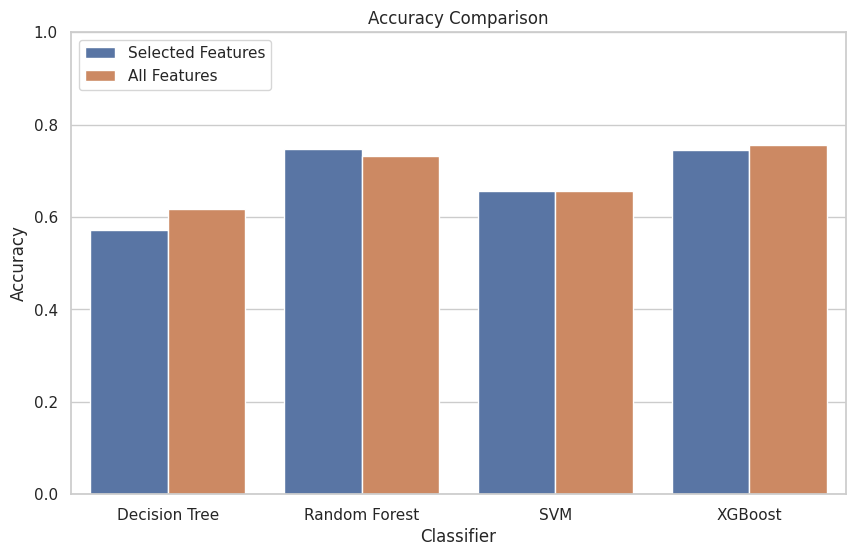

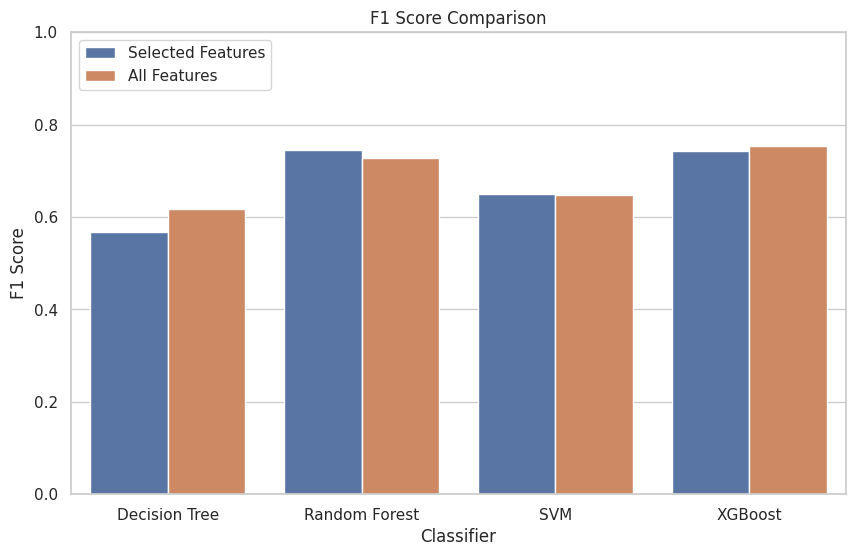

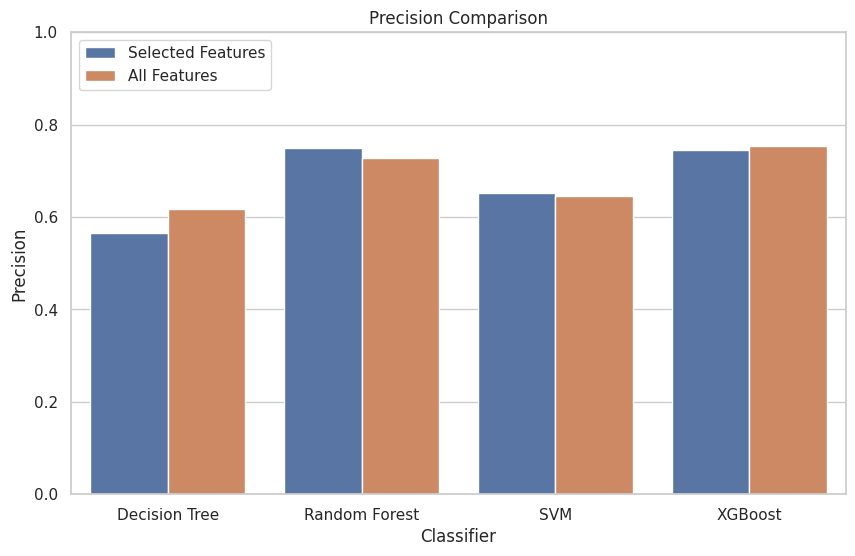

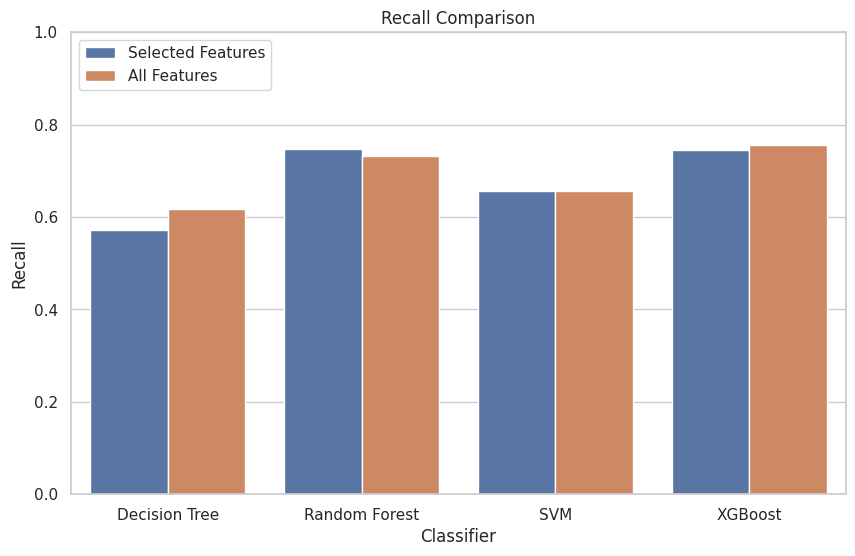

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_csv('/content/new_updated.csv')

# Define selected features from GA
selected_features = ['t_wave_peak_value_ch1', 'qrs_duration_ch1', 'bpm_ch1', 'st_depression_ch1', 'st_deviation_ch1', 'correlation_t_st_ch1', 't_wave_peak_value_ch2', 't_wave_inversion_ch2', 'rr_mean_ch2', 'st_elevation_ch2', 'correlation_t_st_ch2', 't_wave_inversion_ch3', 't_wave_flattening_ch3', 'rr_mean_ch3', 'qrs_duration_ch3', 'bpm_ch3', 'st_elevation_ch3', 'st_deviation_ch3', 't_wave_duration_ch4', 't_wave_peak_value_ch4', 't_wave_flattening_ch4', 'rr_mean_ch4', 'qrs_amplitude_ch4', 'bpm_ch4', 'correlation_t_st_ch4', 't_wave_duration_ch5', 't_wave_flattening_ch5', 'st_deviation_ch5', 't_wave_peak_value_ch6', 't_wave_inversion_ch6', 't_wave_flattening_ch6', 'qrs_duration_ch6', 'correlation_t_st_ch6', 't_wave_peak_value_ch7', 't_wave_inversion_ch7', 't_wave_flattening_ch7', 'qrs_amplitude_ch7', 'p_wave_duration_ch7', 'st_elevation_ch7', 'st_deviation_ch7', 'correlation_t_st_ch7', 't_wave_duration_ch8', 't_wave_peak_value_ch8', 't_wave_inversion_ch8', 't_wave_flattening_ch8', 'qrs_duration_ch8', 'correlation_t_st_ch8', 't_wave_duration_ch9', 't_wave_inversion_ch9', 't_wave_flattening_ch9', 'qrs_duration_ch9', 'st_deviation_ch9', 'correlation_t_st_ch9', 't_wave_duration_ch10', 't_wave_peak_value_ch10', 't_wave_inversion_ch10', 't_wave_flattening_ch10', 'qrs_amplitude_ch10', 'bpm_ch10', 'st_depression_ch10', 'st_deviation_ch10', 't_wave_duration_ch11', 't_wave_peak_value_ch11', 't_wave_inversion_ch11', 't_wave_flattening_ch11', 'qrs_duration_ch11', 'st_deviation_ch11', 'correlation_t_st_ch11', 't_wave_peak_value_ch12', 't_wave_inversion_ch12', 'bpm_ch12', 'p_wave_duration_ch12', 'st_elevation_ch12', 'st_deviation_ch12', 'correlation_t_st_ch12']

# Extract all feature columns
all_features = df.columns.tolist()[2:]

# Define the classifiers
classifiers = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(kernel='linear', random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

# Function to process the data and compute metrics
def compute_metrics(features):
    X = df[features]
    y = df['AHA_Code']
    X = X.fillna(0)
    y = y.fillna(0)
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y_encoded)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_resampled)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_resampled, test_size=0.2, random_state=42)
    metrics = {
        "Classifier": [],
        "Accuracy": [],
        "F1 Score": [],
        "Precision": [],
        "Recall": []
    }
    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        metrics["Classifier"].append(name)
        metrics["Accuracy"].append(accuracy_score(y_test, y_pred))
        metrics["F1 Score"].append(f1_score(y_test, y_pred, average='weighted'))
        metrics["Precision"].append(precision_score(y_test, y_pred, average='weighted'))
        metrics["Recall"].append(recall_score(y_test, y_pred, average='weighted'))
    return pd.DataFrame(metrics)

# Compute metrics for selected features
metrics_selected = compute_metrics(selected_features)

# Compute metrics for all features
metrics_all = compute_metrics(all_features)

# Add a column indicating the feature set
metrics_selected['Feature Set'] = 'Selected Features'
metrics_all['Feature Set'] = 'All Features'

# Combine the metrics DataFrames
metrics_combined = pd.concat([metrics_selected, metrics_all])

# Set the seaborn style
sns.set(style="whitegrid")

# Plot the metrics as bar graphs
metrics_melted = metrics_combined.melt(id_vars=["Classifier", "Feature Set"], var_name="Metric", value_name="Score")

for metric in ["Accuracy", "F1 Score", "Precision", "Recall"]:
    plt.figure(figsize=(10, 6))
    sns.barplot(data=metrics_melted[metrics_melted["Metric"] == metric],
                x="Classifier", y="Score", hue="Feature Set")
    plt.title(f"{metric} Comparison")
    plt.ylabel(metric)
    plt.xlabel("Classifier")
    plt.ylim(0, 1)  # Assuming all metrics are between 0 and 1
    plt.legend(loc='upper left')
    plt.show()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_16 (Conv1D)          (None, 10, 64)            384064    
                                                                 
 max_pooling1d_16 (MaxPooli  (None, 5, 64)             0         
 ng1D)                                                           
                                                                 
 conv1d_17 (Conv1D)          (None, 3, 32)             6176      
                                                                 
 max_pooling1d_17 (MaxPooli  (None, 1, 32)             0         
 ng1D)                                                           
                                                                 
 flatten_8 (Flatten)         (None, 32)                0         
                                                                 
 dense_24 (Dense)            (None, 128)              

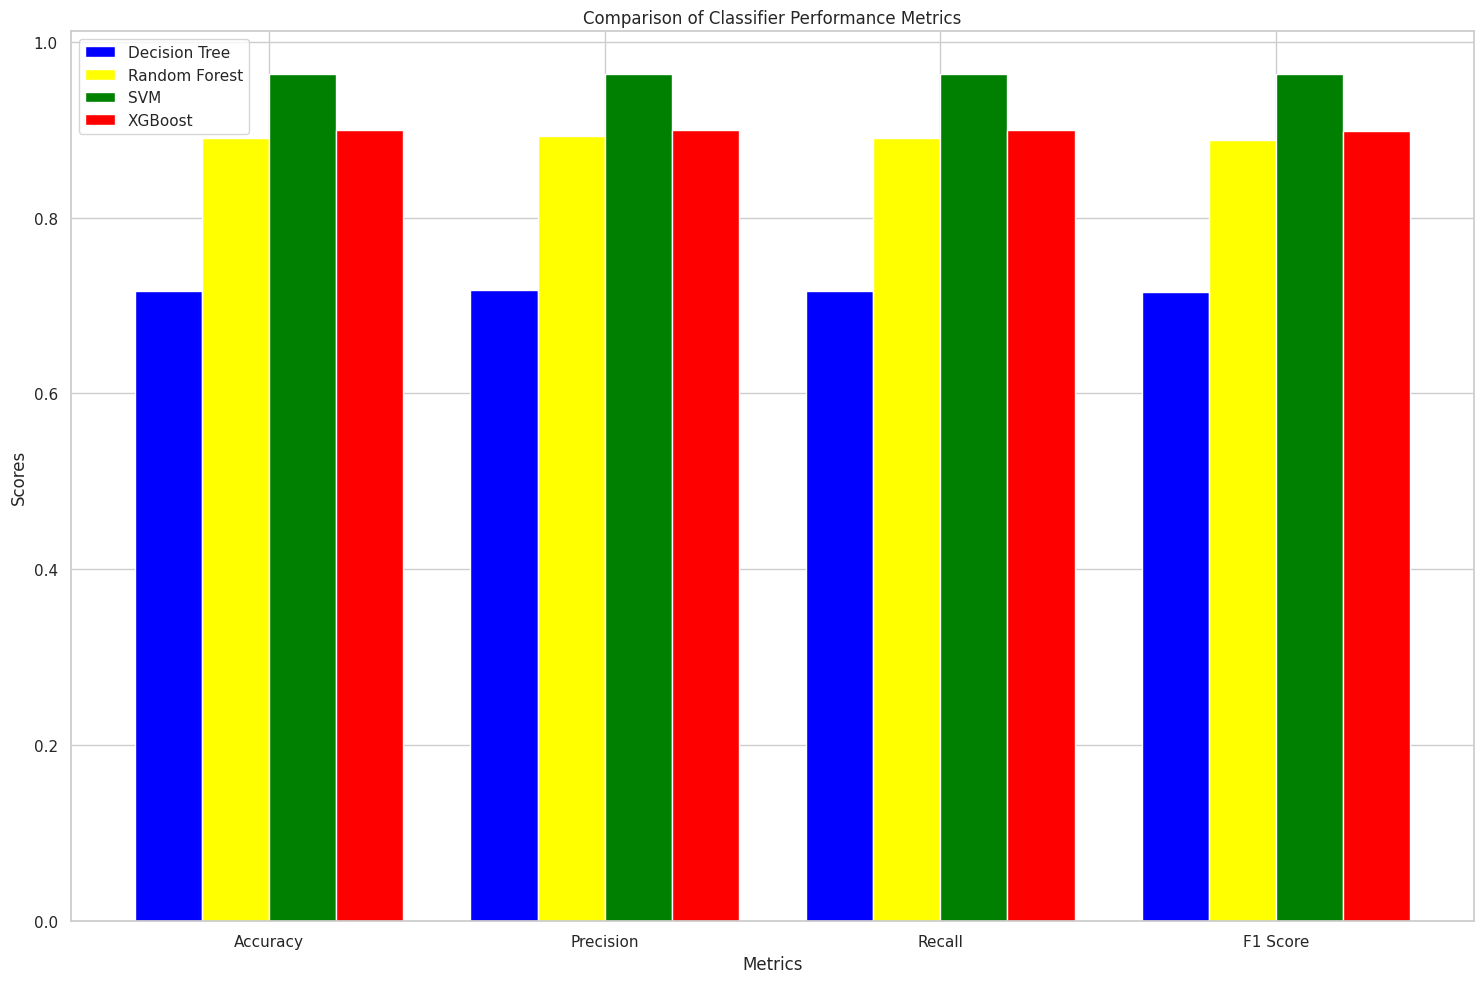

In [ ]:
import os
import h5py
import random
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Load the metadata
metadata_path = '/content/drive/MyDrive/metadata (1).csv'
metadata = pd.read_csv(metadata_path)

# Load the ECG data
def load_h5_file(file_path):
    with h5py.File(file_path, 'r') as f:
        data = f['ecg'][:]
    return data

def load_ptbxl_dataset(directory_path, metadata):
    all_data = []
    labels = []
    for _, row in metadata.iterrows():
        ecg_id = row['ECG_ID']
        label = row['AHA_Code'].split(';')[0]  # Taking the first code if multiple are present
        file_path = os.path.join(directory_path, f'{ecg_id}.h5')
        if os.path.exists(file_path):
            data = load_h5_file(file_path)
            all_data.append(data)
            labels.append(int(label))
    return np.array(all_data), np.array(labels)

# Load the dataset
directory_path = '/content/drive/MyDrive/h5files'
data, labels = load_ptbxl_dataset(directory_path, metadata)

# Determine the number of unique classes
unique_labels = np.unique(labels)
num_classes = len(unique_labels)

# Create a mapping from original labels to a sequential range of integers
label_mapping = {original_label: idx for idx, original_label in enumerate(unique_labels)}
mapped_labels = np.array([label_mapping[label] for label in labels])

# Apply robust scaling
scaler = RobustScaler()
num_samples, num_leads, num_points = data.shape[0], data.shape[1], data.shape[2]
data_flattened = data.reshape(num_samples * num_leads, num_points)
data_scaled = scaler.fit_transform(data_flattened)
data_scaled = data_scaled.reshape(num_samples, num_leads, num_points)

# Define the CNN model
def build_cnn(input_shape, num_classes):
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Conv1D(32, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.1),
        Dense(64, activation='relu'),
        Dropout(0.1),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Convert labels to categorical
labels_categorical = tf.keras.utils.to_categorical(mapped_labels, num_classes=num_classes)

# Build and train the CNN
cnn_model = build_cnn(input_shape=(num_leads, num_points), num_classes=num_classes)
cnn_model.summary()

# Train the CNN
cnn_model.fit(data_scaled, labels_categorical, epochs=10, batch_size=32)

# Extract features using the CNN
feature_extractor = tf.keras.Model(inputs=cnn_model.input, outputs=cnn_model.layers[-6].output)
features = feature_extractor.predict(data_scaled)
print(features.shape)

# Train and evaluate classifiers
X_train, X_test, y_train, y_test = train_test_split(features, mapped_labels, test_size=0.2, random_state=42)

# Initialize classifiers
rf_classifier = RandomForestClassifier(n_estimators=100)
dt_classifier = DecisionTreeClassifier()
svm_classifier = SVC()
xgb_classifier = XGBClassifier()

# Dictionary to store metrics
metrics = {}

# Train and evaluate Decision Tree classifier
dt_classifier.fit(X_train, y_train)
y_pred_dt = dt_classifier.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt, average='weighted')
recall_dt = recall_score(y_test, y_pred_dt, average='weighted')
f1_dt = f1_score(y_test, y_pred_dt, average='weighted')
metrics['Decision Tree'] = {'Accuracy': accuracy_dt, 'Precision': precision_dt, 'Recall': recall_dt, 'F1 Score': f1_dt}


# Train and evaluate Random Forest classifier
rf_classifier.fit(X_train, y_train)
y_pred_rf = rf_classifier.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, average='weighted')
recall_rf = recall_score(y_test, y_pred_rf, average='weighted')
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')
metrics['Random Forest'] = {'Accuracy': accuracy_rf, 'Precision': precision_rf, 'Recall': recall_rf, 'F1 Score': f1_rf}

# Train and evaluate SVM classifier
svm_classifier.fit(X_train, y_train)
y_pred_svm = svm_classifier.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm, average='weighted')
recall_svm = recall_score(y_test, y_pred_svm, average='weighted')
f1_svm = f1_score(y_test, y_pred_svm, average='weighted')
metrics['SVM'] = {'Accuracy': accuracy_svm, 'Precision': precision_svm, 'Recall': recall_svm, 'F1 Score': f1_svm}

# Train and evaluate XGBoost classifier
xgb_classifier.fit(X_train, y_train)
y_pred_xgb = xgb_classifier.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb, average='weighted')
recall_xgb = recall_score(y_test, y_pred_xgb, average='weighted')
f1_xgb = f1_score(y_test, y_pred_xgb, average='weighted')
metrics['XGBoost'] = {'Accuracy': accuracy_xgb, 'Precision': precision_xgb, 'Recall': recall_xgb, 'F1 Score': f1_xgb}

# Create a DataFrame for metrics
metrics_df = pd.DataFrame(metrics)

# Plot the metrics
fig, ax = plt.subplots(figsize=(15, 10))

index = np.arange(len(metrics_df))
bar_width = 0.2

bar1 = ax.bar(index, metrics_df['Decision Tree'], bar_width, label='Decision Tree', color='blue')
bar2 = ax.bar(index + bar_width, metrics_df['Random Forest'], bar_width, label='Random Forest', color='yellow')
bar3 = ax.bar(index + 2 * bar_width, metrics_df['SVM'], bar_width, label='SVM', color='green')
bar4 = ax.bar(index + 3 * bar_width, metrics_df['XGBoost'], bar_width, label='XGBoost', color='red')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Classifier Performance Metrics')
ax.set_xticks(index + 1.5 * bar_width)
ax.set_xticklabels(metrics_df.index)
ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
import os

# List files in the directory to confirm the correct file path
directory_path = '/content/drive/MyDrive/records1/records/A00002/'  # Replace with your directory path

# Print all files in the directory
print("Files in directory:")
for file_name in os.listdir(directory_path):
    print(file_name)

# Load ECG data function
def load_h5_file(file_path):
    with h5py.File(file_path, 'r') as f:
        time = f['time'][:]  # Assuming the dataset for time is named 'time'
        ecg_signal = f['ecg'][:]  # Assuming the dataset for ECG signal is named 'ecg'
    return time, ecg_signal

# Correct path to the HDF5 file
file_path = os.path.join(directory_path, 'A00002')  # Replace with the correct file name

# Load the ECG data
try:
    time, ecg_signal = load_h5_file(file_path)
    print("ECG data loaded successfully.")
except FileNotFoundError:
    print(f"File not found: {file_path}")
    raise

# Plotting the ECG signal with annotations
plt.figure(figsize=(12, 6))
plt.plot(time, ecg_signal, label='ECG Signal', color='black')

# Annotate PQRST (example locations, you may need to adjust based on your data)
plt.axvspan(time[0], time[int(0.1*len(time))], color='pink', alpha=0.5, label='P Wave')
plt.axvspan(time[int(0.1*len(time))], time[int(0.2*len(time))], color='orange', alpha=0.5, label='PR Segment')
plt.axvspan(time[int(0.2*len(time))], time[int(0.3*len(time))], color='yellow', alpha=0.5, label='QRS Complex')
plt.axvspan(time[int(0.3*len(time))], time[int(0.4*len(time))], color='green', alpha=0.5, label='ST Segment')
plt.axvspan(time[int(0.4*len(time))], time[int(0.6*len(time))], color='blue', alpha=0.5, label='T Wave')

# Add text labels for intervals (example locations)
plt.text(time[int(0.05*len(time))], min(ecg_signal), 'PR Interval', fontsize=12, ha='center', color='brown')
plt.text(time[int(0.5*len(time))], min(ecg_signal), 'QT Interval', fontsize=12, ha='center', color='brown')

plt.title('ECG Signal with PQRST Waves')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


Files in directory:


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/records1/records/A00002/'

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 10, 64)            384064    
                                                                 
 max_pooling1d (MaxPooling1  (None, 5, 64)             0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 3, 32)             6176      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 1, 32)             0         
 g1D)                                                            
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 128)               4

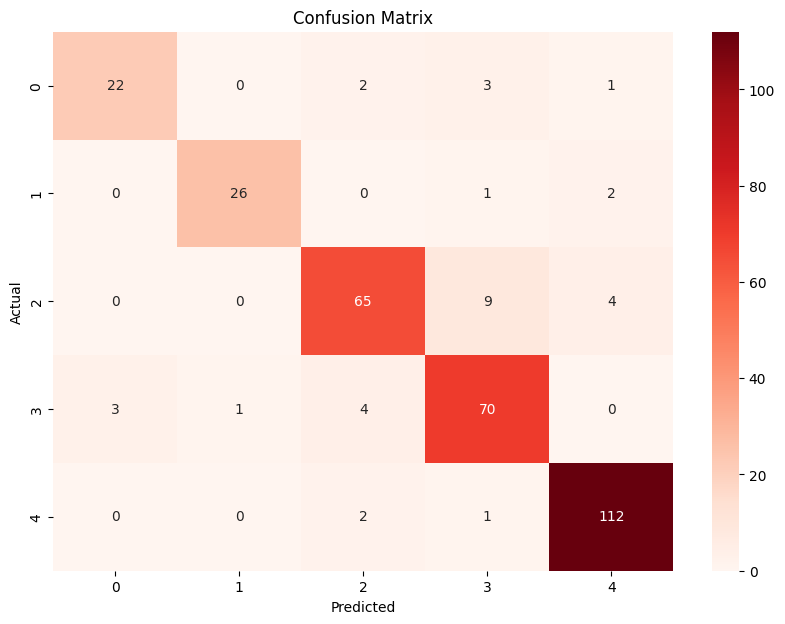

In [ ]:

import os
import h5py
import random
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
random.seed(42)

# Load the metadata
metadata_path = '/content/drive/MyDrive/metadata (1).csv'
metadata = pd.read_csv(metadata_path)

# Load the ECG data
def load_h5_file(file_path):
    with h5py.File(file_path, 'r') as f:
        data = f['ecg'][:]
    return data

def load_ptbxl_dataset(directory_path, metadata):
    all_data = []
    labels = []
    for _, row in metadata.iterrows():
        ecg_id = row['ECG_ID']
        label = row['AHA_Code'].split(';')[0]  # Taking the first code if multiple are present
        file_path = os.path.join(directory_path, f'{ecg_id}.h5')
        if os.path.exists(file_path):
            data = load_h5_file(file_path)
            all_data.append(data)
            labels.append(int(label))
    return np.array(all_data), np.array(labels)

# Load the dataset
directory_path = '/content/drive/MyDrive/h5files'
data, labels = load_ptbxl_dataset(directory_path, metadata)

# Determine the number of unique classes
unique_labels = np.unique(labels)
num_classes = len(unique_labels)

# Create a mapping from original labels to a sequential range of integers
label_mapping = {original_label: idx for idx, original_label in enumerate(unique_labels)}
mapped_labels = np.array([label_mapping[label] for label in labels])

# Apply robust scaling
scaler = RobustScaler()
num_samples, num_leads, num_points = data.shape[0], data.shape[1], data.shape[2]
data_flattened = data.reshape(num_samples * num_leads, num_points)
data_scaled = scaler.fit_transform(data_flattened)
data_scaled = data_scaled.reshape(num_samples, num_leads, num_points)

# Define the CNN model
def build_cnn(input_shape, num_classes):
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Conv1D(32, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.1),
        Dense(64, activation='relu'),
        Dropout(0.1),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Convert labels to categorical
labels_categorical = tf.keras.utils.to_categorical(mapped_labels, num_classes=num_classes)

# Build and train the CNN
cnn_model = build_cnn(input_shape=(num_leads, num_points), num_classes=num_classes)
cnn_model.summary()

# Train the CNN
cnn_model.fit(data_scaled, labels_categorical, epochs= 10, batch_size=32)

# Extract features using the CNN
feature_extractor = tf.keras.Model(inputs=cnn_model.input, outputs=cnn_model.layers[-6].output)
features = feature_extractor.predict(data_scaled)
print(features.shape)

# Train and evaluate a Random Forest classifier
X_train, X_test, y_train, y_test = train_test_split(features, mapped_labels, test_size=0.2, random_state=42)
rf_classifier = RandomForestClassifier(n_estimators=100)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest accuracy: {accuracy:.2f}")

# Generate and print the classification report
class_report = classification_report(y_test, y_pred)
print("\nClassification Report:\n", class_report)

# Plot confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `features` is the array with shape (1637, 32)

# Convert the features array to a DataFrame
features_df = pd.DataFrame(features)

# Display the first few rows of the DataFrame to get an idea of the feature values
print(features_df.head(20))



           0        1    2          3          4         5         6   \
0    0.000000  0.00000  0.0   7.745842   0.000000  0.000000  2.679716   
1    0.000000  0.00000  0.0   0.472373   0.000000  0.000000  0.000000   
2    0.000000  0.00000  0.0   0.000000   1.727353  0.000000  0.000000   
3    0.000000  0.00000  0.0   0.000000  21.285276  1.369106  0.000000   
4    0.000000  0.00000  0.0   0.000000  11.903761  0.000000  0.000000   
5    0.000000  0.00000  0.0   0.000000   0.000000  2.307476  0.000000   
6    0.000000  0.00000  0.0   5.651458   0.412896  8.096300  0.000000   
7    0.000000  0.00000  0.0   0.000000   0.000000  0.000000  0.000000   
8    0.000000  0.00000  0.0   0.000000   1.563982  0.000000  0.000000   
9    0.000000  0.00000  0.0   0.000000   0.000000  0.000000  0.000000   
10   0.000000  0.00000  0.0   0.000000   2.149512  0.000000  7.881336   
11   5.281312  0.00000  0.0   0.000000   0.528414  0.000000  0.000000   
12   0.000000  2.80602  0.0   0.000000   6.528745  

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 10, 64)            384064    
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 5, 64)             0         
 g1D)                                                            
                                                                 
 conv1d_7 (Conv1D)           (None, 3, 32)             6176      
                                                                 
 max_pooling1d_7 (MaxPoolin  (None, 1, 32)             0         
 g1D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 32)                0         
                                                                 
 dense_9 (Dense)             (None, 128)              

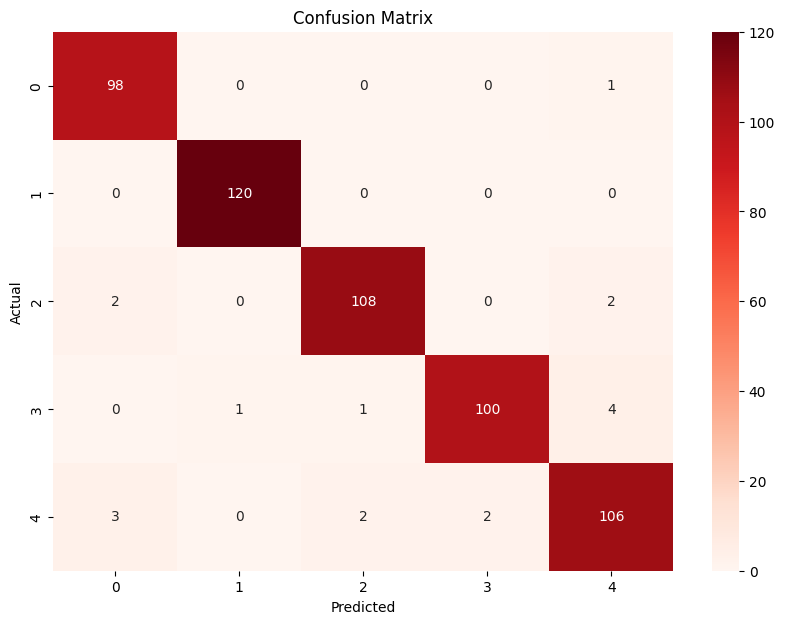

In [ ]:
import os
import h5py
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

# Load the metadata
metadata_path = '/content/drive/MyDrive/metadata (1).csv'
metadata = pd.read_csv(metadata_path)

# Load the ECG data
def load_h5_file(file_path):
    with h5py.File(file_path, 'r') as f:
        data = f['ecg'][:]
    return data

def load_ptbxl_dataset(directory_path, metadata):
    all_data = []
    labels = []
    ecg_ids = []
    for _, row in metadata.iterrows():
        ecg_id = row['ECG_ID']
        label = row['AHA_Code'].split(';')[0]  # Taking the first code if multiple are present
        file_path = os.path.join(directory_path, f'{ecg_id}.h5')
        if os.path.exists(file_path):
            data = load_h5_file(file_path)
            all_data.append(data)
            labels.append(int(label))
            ecg_ids.append(ecg_id)
    return np.array(all_data), np.array(labels), np.array(ecg_ids)

# Load the dataset
directory_path = '/content/drive/MyDrive/h5files'
data, labels, ecg_ids = load_ptbxl_dataset(directory_path, metadata)

# Determine the number of unique classes
unique_labels = np.unique(labels)
num_classes = len(unique_labels)

# Create a mapping from original labels to a sequential range of integers
label_mapping = {original_label: idx for idx, original_label in enumerate(unique_labels)}
mapped_labels = np.array([label_mapping[label] for label in labels])

# Apply robust scaling
scaler = RobustScaler()
num_samples, num_leads, num_points = data.shape[0], data.shape[1], data.shape[2]
data_flattened = data.reshape(num_samples * num_leads, num_points)
data_scaled = scaler.fit_transform(data_flattened)
data_scaled = data_scaled.reshape(num_samples, num_leads, num_points)

# Define the CNN model
def build_cnn(input_shape, num_classes):
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Conv1D(32, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.1),
        Dense(64, activation='relu'),
        Dropout(0.1),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Convert labels to categorical
labels_categorical = tf.keras.utils.to_categorical(mapped_labels, num_classes=num_classes)

# Build and train the CNN
cnn_model = build_cnn(input_shape=(num_leads, num_points), num_classes=num_classes)
cnn_model.summary()
cnn_model.fit(data_scaled, labels_categorical, epochs=10, batch_size=32)

# Extract features using the CNN
feature_extractor = tf.keras.Model(inputs=cnn_model.input, outputs=cnn_model.layers[-6].output)
features = feature_extractor.predict(data_scaled)

# Create a DataFrame for the features
features_df = pd.DataFrame(features, index=ecg_ids, columns=[f'feature_{i}' for i in range(features.shape[1])])

# Print the features for the first 20 samples
print(features_df.head(20))

# Save the features to a CSV file
features_df.to_csv('/content/drive/MyDrive/ecg_features.csv', index_label='ECG_ID')
print("Number of features before SMOTE:", features.shape[1])
# Apply SMOTE to the extracted features
smote = SMOTE(random_state=42)
balanced_features, balanced_labels = smote.fit_resample(features, mapped_labels)
print("Number of features after SMOTE:", balanced_features.shape[1])
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(balanced_features, balanced_labels, test_size=0.2, random_state=42)

# Train a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=120, random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest accuracy: {accuracy:.2f}")

# Generate and print the classification report
class_report = classification_report(y_test, y_pred)
print("\nClassification Report:\n", class_report)

# Plot confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
!pip install xgboost
!pip install imbalanced-learn
!pip install seaborn


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 10, 64)            384064    
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 5, 64)             0         
 g1D)                                                            
                                                                 
 conv1d_3 (Conv1D)           (None, 3, 32)             6176      
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 1, 32)             0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 128)              

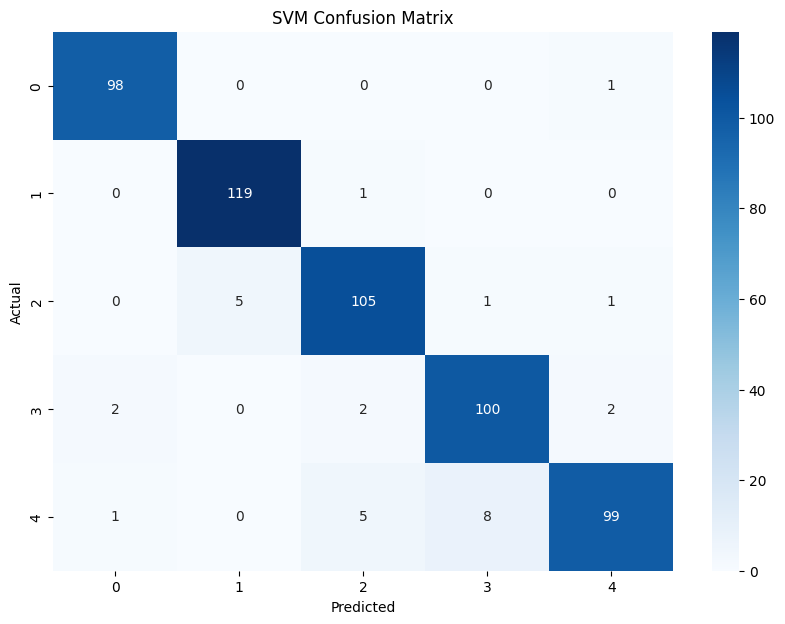

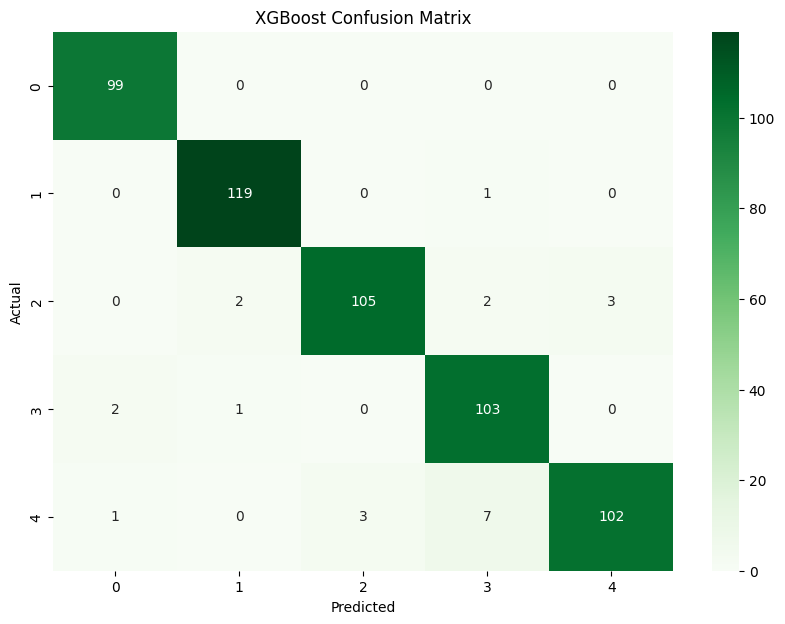

In [ ]:
import os
import h5py
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.svm import SVC
import xgboost as xgb

# Load the metadata
metadata_path = '/content/drive/MyDrive/metadata (1).csv'
metadata = pd.read_csv(metadata_path)

# Load the ECG data
def load_h5_file(file_path):
    with h5py.File(file_path, 'r') as f:
        data = f['ecg'][:]
    return data

def load_ptbxl_dataset(directory_path, metadata):
    all_data = []
    labels = []
    ecg_ids = []
    for _, row in metadata.iterrows():
        ecg_id = row['ECG_ID']
        label = row['AHA_Code'].split(';')[0]  # Taking the first code if multiple are present
        file_path = os.path.join(directory_path, f'{ecg_id}.h5')
        if os.path.exists(file_path):
            data = load_h5_file(file_path)
            all_data.append(data)
            labels.append(int(label))
            ecg_ids.append(ecg_id)
    return np.array(all_data), np.array(labels), np.array(ecg_ids)

# Load the dataset
directory_path = '/content/drive/MyDrive/h5files'
data, labels, ecg_ids = load_ptbxl_dataset(directory_path, metadata)

# Determine the number of unique classes
unique_labels = np.unique(labels)
num_classes = len(unique_labels)

# Create a mapping from original labels to a sequential range of integers
label_mapping = {original_label: idx for idx, original_label in enumerate(unique_labels)}
mapped_labels = np.array([label_mapping[label] for label in labels])

# Apply robust scaling
scaler = RobustScaler()
num_samples, num_leads, num_points = data.shape[0], data.shape[1], data.shape[2]
data_flattened = data.reshape(num_samples * num_leads, num_points)
data_scaled = scaler.fit_transform(data_flattened)
data_scaled = data_scaled.reshape(num_samples, num_leads, num_points)

# Define the CNN model
def build_cnn(input_shape, num_classes):
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Conv1D(32, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.1),
        Dense(64, activation='relu'),
        Dropout(0.1),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Convert labels to categorical
labels_categorical = tf.keras.utils.to_categorical(mapped_labels, num_classes=num_classes)

# Build and train the CNN
cnn_model = build_cnn(input_shape=(num_leads, num_points), num_classes=num_classes)
cnn_model.summary()
cnn_model.fit(data_scaled, labels_categorical, epochs=10, batch_size=32)

# Extract features using the CNN
feature_extractor = tf.keras.Model(inputs=cnn_model.input, outputs=cnn_model.layers[-6].output)
features = feature_extractor.predict(data_scaled)

# Apply SMOTE to the extracted features
smote = SMOTE(random_state=42)
balanced_features, balanced_labels = smote.fit_resample(features, mapped_labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(balanced_features, balanced_labels, test_size=0.2, random_state=42)

# Train and evaluate SVM
svm_classifier = SVC(kernel='linear', random_state=42)
svm_classifier.fit(X_train, y_train)
y_pred_svm = svm_classifier.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"SVM accuracy: {accuracy_svm:.2f}")
class_report_svm = classification_report(y_test, y_pred_svm)
print("\nSVM Classification Report:\n", class_report_svm)

# Train and evaluate XGBoost
xgb_classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_classifier.fit(X_train, y_train)
y_pred_xgb = xgb_classifier.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost accuracy: {accuracy_xgb:.2f}")
class_report_xgb = classification_report(y_test, y_pred_xgb)
print("\nXGBoost Classification Report:\n", class_report_xgb)

# Plot confusion matrix for SVM
conf_mat_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat_svm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('SVM Confusion Matrix')
plt.show()

# Plot confusion matrix for XGBoost
conf_mat_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat_xgb, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('XGBoost Confusion Matrix')
plt.show()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 10, 64)            384064    
                                                                 
 max_pooling1d_8 (MaxPoolin  (None, 5, 64)             0         
 g1D)                                                            
                                                                 
 conv1d_9 (Conv1D)           (None, 3, 32)             6176      
                                                                 
 max_pooling1d_9 (MaxPoolin  (None, 1, 32)             0         
 g1D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 32)                0         
                                                                 
 dense_12 (Dense)            (None, 128)              

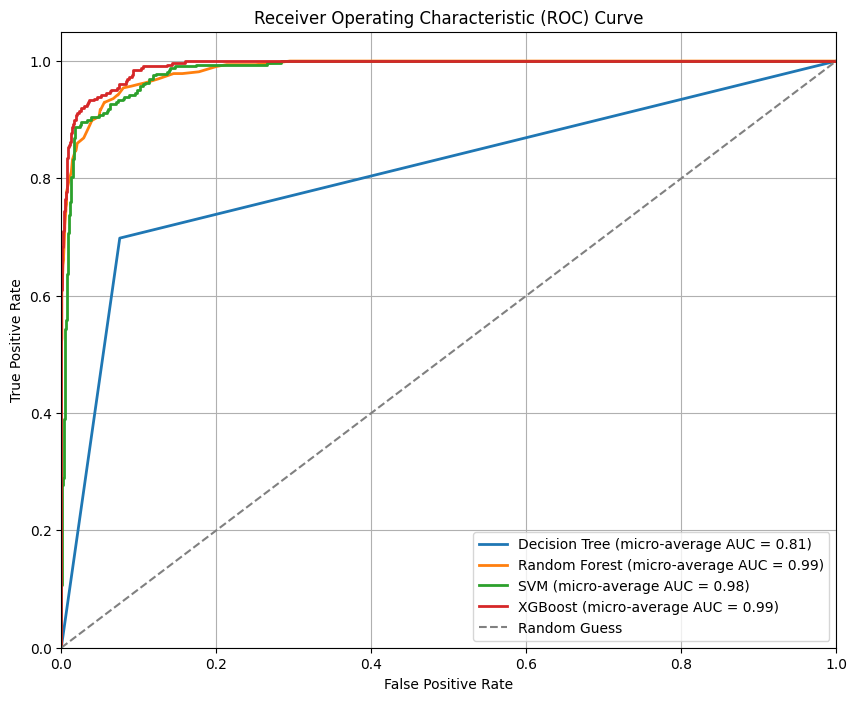

In [ ]:
import os
import h5py
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.svm import SVC
import xgboost as xgb

# Load the metadata
metadata_path = '/content/drive/MyDrive/metadata (1).csv'
metadata = pd.read_csv(metadata_path)

# Load the ECG data
def load_h5_file(file_path):
    with h5py.File(file_path, 'r') as f:
        data = f['ecg'][:]
    return data

def load_ptbxl_dataset(directory_path, metadata):
    all_data = []
    labels = []
    ecg_ids = []
    for _, row in metadata.iterrows():
        ecg_id = row['ECG_ID']
        label = row['AHA_Code'].split(';')[0]  # Taking the first code if multiple are present
        file_path = os.path.join(directory_path, f'{ecg_id}.h5')
        if os.path.exists(file_path):
            data = load_h5_file(file_path)
            all_data.append(data)
            labels.append(int(label))
            ecg_ids.append(ecg_id)
    return np.array(all_data), np.array(labels), np.array(ecg_ids)

# Load the dataset
directory_path = '/content/drive/MyDrive/h5files'
data, labels, ecg_ids = load_ptbxl_dataset(directory_path, metadata)

# Determine the number of unique classes
unique_labels = np.unique(labels)
num_classes = len(unique_labels)

# Create a mapping from original labels to a sequential range of integers
label_mapping = {original_label: idx for idx, original_label in enumerate(unique_labels)}
mapped_labels = np.array([label_mapping[label] for label in labels])

# Apply robust scaling
scaler = RobustScaler()
num_samples, num_leads, num_points = data.shape[0], data.shape[1], data.shape[2]
data_flattened = data.reshape(num_samples * num_leads, num_points)
data_scaled = scaler.fit_transform(data_flattened)
data_scaled = data_scaled.reshape(num_samples, num_leads, num_points)

# Define the CNN model
def build_cnn(input_shape, num_classes):
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Conv1D(32, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.1),
        Dense(64, activation='relu'),
        Dropout(0.1),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Convert labels to categorical
labels_categorical = tf.keras.utils.to_categorical(mapped_labels, num_classes=num_classes)

# Build and train the CNN
cnn_model = build_cnn(input_shape=(num_leads, num_points), num_classes=num_classes)
cnn_model.summary()
cnn_model.fit(data_scaled, labels_categorical, epochs=10, batch_size=32)

# Extract features using the CNN
feature_extractor = tf.keras.Model(inputs=cnn_model.input, outputs=cnn_model.layers[-6].output)
features = feature_extractor.predict(data_scaled)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, mapped_labels, test_size=0.2, random_state=42)

# Initialize classifiers
classifiers = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(kernel='linear', random_state=42, probability=True),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

# Plot ROC curve for each classifier
plt.figure(figsize=(10, 8))
for clf_name, clf in classifiers.items():
    if clf_name == 'SVM':
        clf.fit(X_train, y_train)
        y_score = clf.decision_function(X_test)
    else:
        clf.fit(X_train, y_train)
        y_score = clf.predict_proba(X_test)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(np.array(pd.get_dummies(y_test))[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(pd.get_dummies(y_test).values.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot ROC curve
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'{clf_name} (micro-average AUC = {roc_auc["micro"]:.2f})',
             linewidth=2)

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 10, 64)            384064    
                                                                 
 max_pooling1d_10 (MaxPooli  (None, 5, 64)             0         
 ng1D)                                                           
                                                                 
 conv1d_11 (Conv1D)          (None, 3, 32)             6176      
                                                                 
 max_pooling1d_11 (MaxPooli  (None, 1, 32)             0         
 ng1D)                                                           
                                                                 
 flatten_5 (Flatten)         (None, 32)                0         
                                                                 
 dense_15 (Dense)            (None, 128)              

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


40/41 [============================>.] - ETA: 0s - loss: 1.4099 - accuracy: 0.4180
Epoch 2: val_accuracy did not improve from 0.30183
41/41 [==============================] - 2s 49ms/step - loss: 1.4215 - accuracy: 0.4156 - val_loss: 1.6254 - val_accuracy: 0.2957
Epoch 3/20
40/41 [============================>.] - ETA: 0s - loss: 1.1742 - accuracy: 0.5375
Epoch 3: val_accuracy did not improve from 0.30183
41/41 [==============================] - 2s 41ms/step - loss: 1.1814 - accuracy: 0.5348 - val_loss: 1.7457 - val_accuracy: 0.2988
Epoch 4/20
41/41 [==============================] - ETA: 0s - loss: 0.9167 - accuracy: 0.6379
Epoch 4: val_accuracy did not improve from 0.30183
Restoring model weights from the end of the best epoch: 1.
41/41 [==============================] - 1s 26ms/step - loss: 0.9167 - accuracy: 0.6379 - val_loss: 1.9785 - val_accuracy: 0.2713
Epoch 4: early stopping


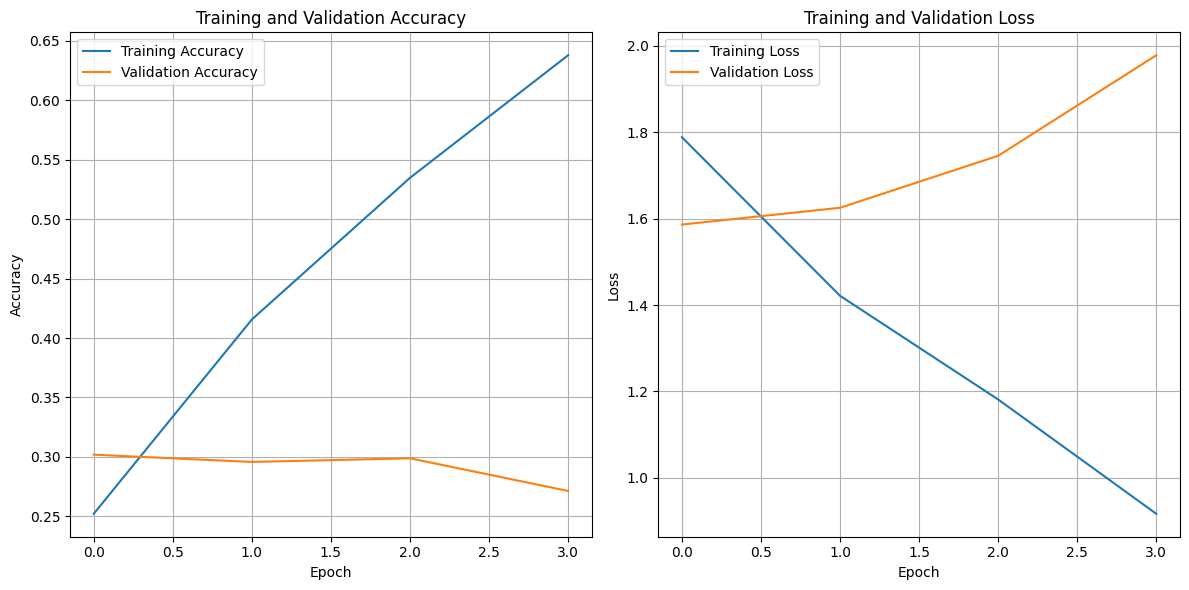

In [ ]:
import os
import h5py
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Load the metadata
metadata_path = '/content/drive/MyDrive/metadata (1).csv'
metadata = pd.read_csv(metadata_path)

# Load the ECG data
def load_h5_file(file_path):
    with h5py.File(file_path, 'r') as f:
        data = f['ecg'][:]
    return data

def load_ptbxl_dataset(directory_path, metadata):
    all_data = []
    labels = []
    ecg_ids = []
    for _, row in metadata.iterrows():
        ecg_id = row['ECG_ID']
        label = row['AHA_Code'].split(';')[0]  # Taking the first code if multiple are present
        file_path = os.path.join(directory_path, f'{ecg_id}.h5')
        if os.path.exists(file_path):
            data = load_h5_file(file_path)
            all_data.append(data)
            labels.append(int(label))
            ecg_ids.append(ecg_id)
    return np.array(all_data), np.array(labels), np.array(ecg_ids)

# Load the dataset
directory_path = '/content/drive/MyDrive/h5files'
data, labels, ecg_ids = load_ptbxl_dataset(directory_path, metadata)

# Determine the number of unique classes
unique_labels = np.unique(labels)
num_classes = len(unique_labels)

# Create a mapping from original labels to a sequential range of integers
label_mapping = {original_label: idx for idx, original_label in enumerate(unique_labels)}
mapped_labels = np.array([label_mapping[label] for label in labels])

# Apply robust scaling
scaler = RobustScaler()
num_samples, num_leads, num_points = data.shape[0], data.shape[1], data.shape[2]
data_flattened = data.reshape(num_samples * num_leads, num_points)
data_scaled = scaler.fit_transform(data_flattened)
data_scaled = data_scaled.reshape(num_samples, num_leads, num_points)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_scaled, mapped_labels, test_size=0.2, random_state=42)

# Define the CNN model
def build_cnn(input_shape, num_classes):
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Conv1D(32, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.1),
        Dense(64, activation='relu'),
        Dropout(0.1),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Build the CNN model
cnn_model = build_cnn(input_shape=(num_leads, num_points), num_classes=num_classes)
cnn_model.summary()

# Define callbacks
checkpoint_path = "best_model.h5"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# Train the CNN model
history = cnn_model.fit(X_train, y_train,
                        epochs=20,
                        batch_size=32,
                        validation_data=(X_test, y_test),
                        callbacks=[checkpoint, early_stopping])

# Plot training history
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
